## Import Packages

In [3]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Utility functions for camera calibration

In [4]:
def find_chessboard_corners(img, rows, cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
    
    if ret == True:
        return objp, corners
    else:
        return None

def calibrate_camera(filenames, rows, cols):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(filenames):
        img = cv2.imread(fname)
        
        # Assume calibration and test images have the same dimensions!
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        res = find_chessboard_corners(img, rows, cols)
        if res is not None:   
            objp, corners = res
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print(fname)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

## Extract object points and image points for camera calibration

['camera_cal/calibration2.jpg']


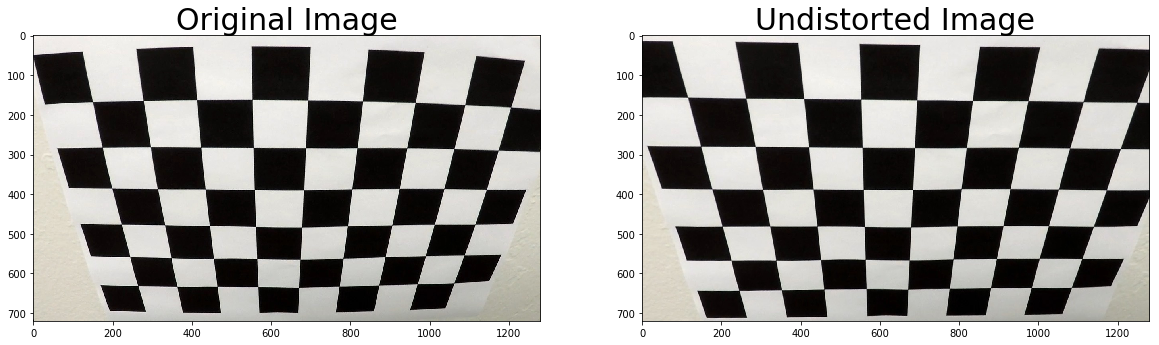

In [5]:
# Define chessboard size
rows = 6
cols = 9

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
images = ['camera_cal/calibration2.jpg']

print(images)

# Get calibration params
mtx, dist = calibrate_camera(images, rows, cols)

# Test undistortion on an image
#img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## Utility functions for filtering an image

In [6]:
def s_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_select(img, thresh=(50,100), sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combine_binary(a, b):
    combined = np.zeros_like(a)
    combined[(a == 1) | (b == 1)] = 1
    return combined

## Test combined S channel and Sobel filter

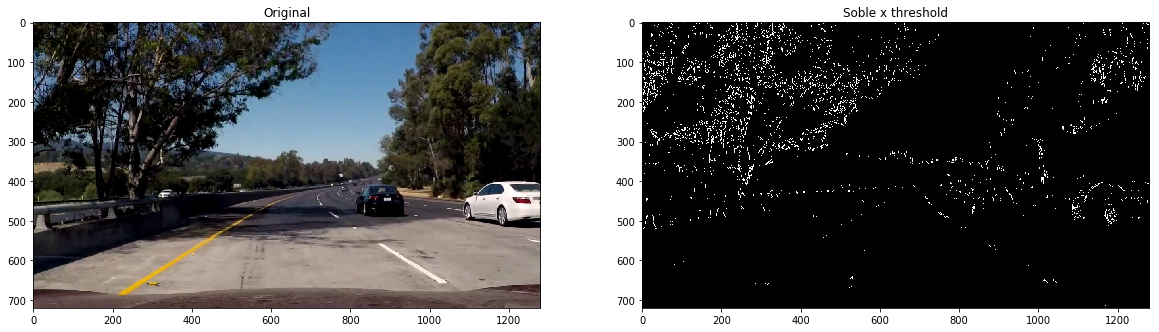

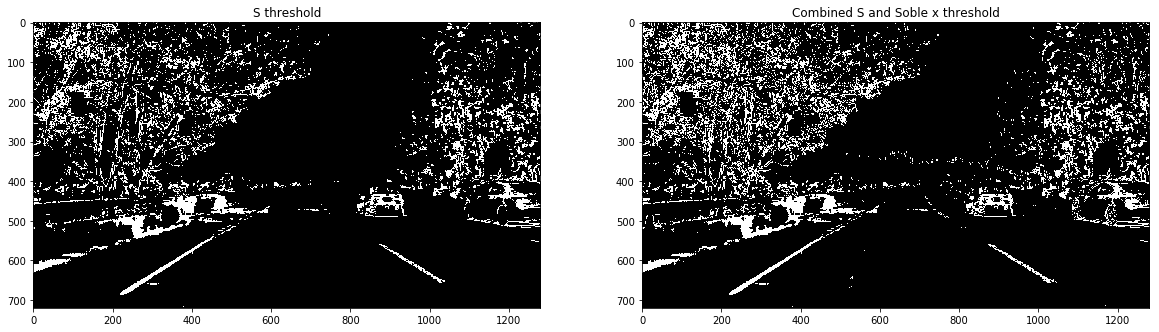

In [7]:
image = cv2.imread('test_images/shadow.jpg') 

s_binary = s_select(image)
sobelx_binary = sobel_select(image, thresh=(50,100))
combined_binary = combine_binary(s_binary, sobelx_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.set_title('Soble x threshold')
ax2.imshow(sobelx_binary, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('S threshold')
ax1.imshow(s_binary, cmap='gray')

ax2.set_title('Combined S and Soble x threshold')
ax2.imshow(combined_binary, cmap='gray')

## Utility functions for perspective transform

In [8]:
def src_dst(img):    
    rows = img.shape[0] - 1
    cols = img.shape[1] - 1
    midx = cols // 2
    midy = rows // 2
    # Define 4 source points
    top = 46
    bottom = 470
    height = 270
    boffset = 20
    toffset = 0
    src = [[midx-bottom+boffset,rows],[midx-top+toffset,rows-height],[midx+top+toffset,rows-height],[midx+bottom+boffset,rows]]
    # Define 4 destination points
    width = 350
    dst = [[midx-width,rows],[midx-width,0],[midx+width,0],[midx+width,rows]]
    return src, dst
    
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(src, np.float32), np.array(dst, np.float32))
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(dst, np.float32), np.array(src, np.float32))
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped


## Test perspective warp

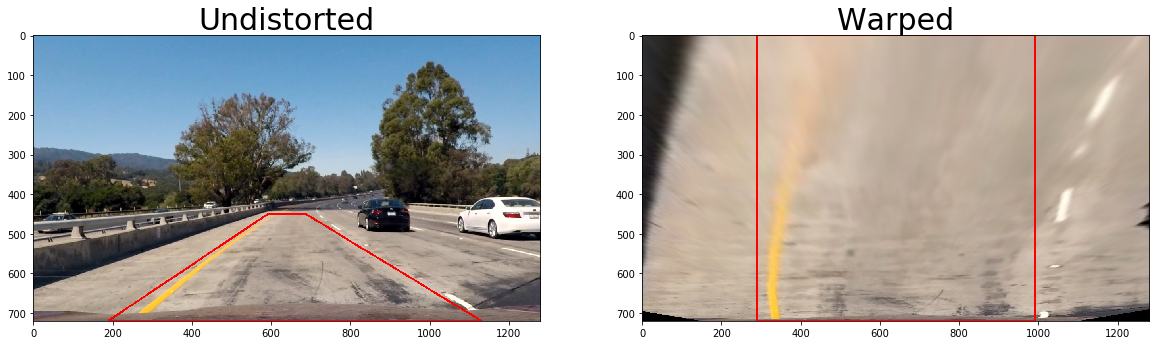

In [9]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
src, dst = src_dst(undist)
warped = warp(undist, src, dst)

# Draw transform polylines on images
undist_copy = undist.copy()
warped_copy = warped.copy()
cv2.polylines(undist_copy,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
cv2.polylines(warped_copy,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_copy)
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped_copy)
ax2.set_title('Warped', fontsize=30)

## Test filter and warp

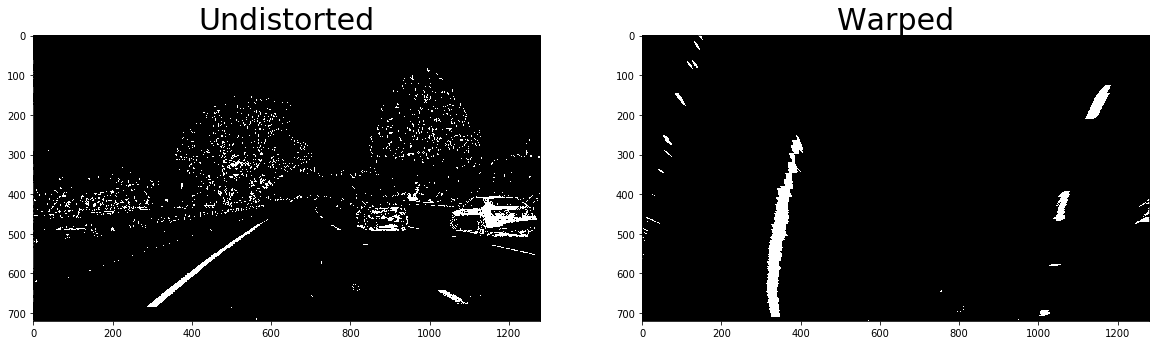

In [10]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
s_binary = s_select(image)
sobelx_binary = sobel_select(image)
combined_binary = combine_binary(s_binary, sobelx_binary)
src, dst = src_dst(combined_binary)
warped = warp(combined_binary, src, dst)

# Draw transform polylines on images
#cv2.polylines(combined_binary,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
#cv2.polylines(warped,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped', fontsize=30)

## Utility functions for histogram with sliding window

In [11]:
def calc_x_poly(fit, y):
    """
    Calculate x given y and fit variables
    """
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    return x
        
def fit_poly(leftx, lefty, rightx, righty):
    """
    Calculates best fit polynomial lines
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50, vis=False):
    """
    Uses histogram to return left and right fit lines
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    if vis is True:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if vis is True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype(int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)

    if vis is True:
        # Plot the polynomial lines onto the image
        img_shape = binary_warped.shape
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = calc_x_poly(left_fit, ploty)
        right_fitx = calc_x_poly(right_fit, ploty)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
        
    return left_fit, right_fit

## Test histogram

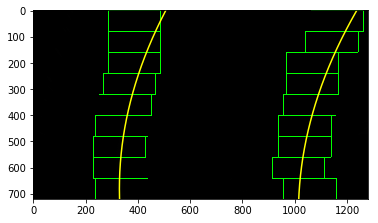

In [12]:
left_fit, right_fit = find_lane_pixels(warped, vis=True)

## Utility functions for window search around prior line

In [13]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=100, vis=False):
    """
    Uses prior best fit lines to return new fit lines
    """
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_val = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    right_val = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    left_lane_inds = (nonzerox > (left_val - margin)) & (nonzerox < (left_val + margin))
    right_lane_inds = (nonzerox > (right_val - margin)) & (nonzerox < (right_val + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    if vis is True:
        img_shape = binary_warped.shape
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = calc_x_poly(left_fit, ploty)
        right_fitx = calc_x_poly(right_fit, ploty)
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.imshow(result)
    
    return left_fit, right_fit

## Test fit window

(array([  3.82564822e-04,  -5.20286638e-01,   5.06447059e+02]),
 array([  3.68912404e-04,  -5.73477808e-01,   1.23661129e+03]))

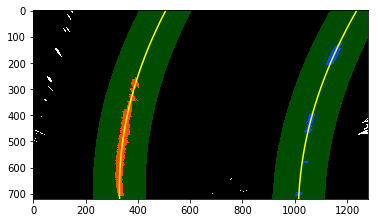

In [14]:
search_around_poly(warped, left_fit, right_fit, vis=True)

## Test curvature

In [15]:
def r_curve(a, b, y):
    return ((1 + (2*a*y + b)**2)**1.5)/np.abs(2*a)
    
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Start by generating our fake example data
# Make sure to feed in your real data instead in your project!
left_fit, right_fit = find_lane_pixels(warped)
img_shape = warped.shape
ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
left_fitx = calc_x_poly(left_fit, ploty)
right_fitx = calc_x_poly(right_fit, ploty)

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Implement the calculation of R_curve (radius of curvature)
left_curverad = r_curve(left_fit[0], left_fit[1], y_eval * ym_per_pix)
right_curverad = r_curve(right_fit[0], left_fit[1], y_eval * ym_per_pix)

print(left_curverad, 'm', right_curverad, 'm')

1820.78528885 m 1884.41775763 m


## Draw lane

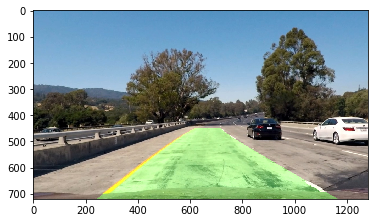

In [18]:
def draw_lanes(binary_warped, undist, left_fit, right_fit):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = calc_x_poly(left_fit, ploty)
    right_fitx = calc_x_poly(right_fit, ploty)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp, src, dst)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = draw_lanes(warped, undist, left_fit, right_fit)
plt.imshow(result)

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
lines = []

def process_image(image):
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # S channel threshold
    s_binary = s_select(image)
    # Sobel x threshold
    sobelx_binary = sobel_select(image)
    # Combined mask
    combined_binary = combine_binary(s_binary, sobelx_binary)
    # Warp to bird's eye
    src, dst = src_dst(combined_binary)
    warped = warp(combined_binary, src, dst)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit polynomial
    if len(lines) is 0:
        left_fit, right_fit = find_lane_pixels(warped)
        lines.append((left_fit, right_fit))
    else:
        left_fit, right_fit = lines[-1]
        nleft_fit, nright_fit = search_around_poly(warped, left_fit, right_fit)
        lines.append((nleft_fit, nright_fit))
        left_fit = nleft_fit
        right_fit = nright_fit
        
    img_shape = warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = calc_x_poly(left_fit, ploty)
    right_fitx = calc_x_poly(right_fit, ploty)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = r_curve(left_fit[0], left_fit[1], y_eval * ym_per_pix)
    right_curverad = r_curve(right_fit[0], left_fit[1], y_eval * ym_per_pix)

    print(left_curverad, 'm', right_curverad, 'm')
    
    result = draw_lanes(warped, undist, left_fit, right_fit)
    
    return result

# image = cv2.imread('test_images/test2.jpg') 
# processed = process_image(image)
# plt.imshow(processed)

output = 'test.mp4'
clip = VideoFileClip('project_video.mp4')
clipout = clip.fl_image(process_image)
%time clipout.write_videofile(output, audio=False)

1730.35608915 m 2762.55397513 m
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  0%|          | 2/1261 [00:00<01:49, 11.53it/s]

1730.35608915 m 2762.55397513 m
1731.0646689 m 2521.51233286 m
1733.84771198 m 2631.56143214 m


  0%|          | 4/1261 [00:00<01:49, 11.53it/s]

1723.09609748 m 2471.15588741 m
1801.81000581 m 2228.79830207 m
1835.67610954 m 2250.50820212 m


  1%|          | 8/1261 [00:00<01:50, 11.29it/s]

1933.58399673 m 2100.10212702 m
1857.37541473 m 2312.27054998 m
2004.20614017 m 2128.82055964 m


  1%|          | 10/1261 [00:00<01:52, 11.10it/s]

2129.57248791 m 2285.55722714 m
2123.25898416 m 1971.00551461 m


  1%|          | 12/1261 [00:01<01:51, 11.23it/s]

2281.98142396 m 2965.47089617 m


  1%|          | 14/1261 [00:01<01:50, 11.27it/s]

2307.8945499 m 2278.23907912 m
2106.3473616 m 2726.31108636 m
2122.31837679 m 2157.82570192 m


  1%|▏         | 16/1261 [00:01<01:50, 11.27it/s]

2024.51496714 m 1828.81910045 m
2014.98531007 m 1744.25805529 m


  1%|▏         | 18/1261 [00:01<01:46, 11.62it/s]

1937.46977578 m 1887.97214518 m
2027.27577823 m 1852.74852742 m
2051.79990097 m 1803.36515589 m


  2%|▏         | 20/1261 [00:01<01:48, 11.40it/s]

2169.11468718 m 2031.83883718 m


  2%|▏         | 22/1261 [00:01<01:49, 11.27it/s]

2192.33508125 m 2090.95337141 m
2174.22528665 m 2045.08769581 m
2001.26319517 m 2337.62171624 m


  2%|▏         | 24/1261 [00:02<01:51, 11.12it/s]

1933.45771859 m 2077.9206835 m
1933.91999404 m 2268.84362436 m


  2%|▏         | 26/1261 [00:02<01:53, 10.84it/s]

1930.08696202 m 2261.70304377 m


  2%|▏         | 28/1261 [00:02<01:53, 10.87it/s]

1960.37877804 m 2428.4583517 m
1841.12619824 m 2106.40010453 m
1687.60848905 m 2407.81371137 m


  3%|▎         | 32/1261 [00:02<01:51, 11.02it/s]

1650.42169374 m 2017.45773868 m
1631.45020783 m 1894.20721173 m
1645.63211838 m 2043.90520374 m


  3%|▎         | 34/1261 [00:03<01:49, 11.23it/s]

1640.24464875 m 1809.6841379 m
1608.45144028 m 2049.79000091 m


  3%|▎         | 36/1261 [00:03<01:47, 11.37it/s]

1614.01193138 m 2185.10355775 m


  3%|▎         | 38/1261 [00:03<01:45, 11.55it/s]

1642.27839747 m 1851.39316548 m
1663.6714871 m 1839.86277459 m
1672.12532098 m 1654.17955937 m


  3%|▎         | 40/1261 [00:03<01:46, 11.45it/s]

1679.25268207 m 1707.7551856 m
1714.58253299 m 1764.07885016 m


  3%|▎         | 42/1261 [00:03<01:45, 11.56it/s]

1748.06309493 m 1769.13833213 m


  3%|▎         | 44/1261 [00:03<01:43, 11.72it/s]

1805.61457261 m 1788.32519961 m
1851.23772988 m 1618.44962678 m
1926.27251289 m 1792.42248731 m


  4%|▎         | 46/1261 [00:04<01:44, 11.66it/s]

1981.84947971 m 1737.46851302 m
1997.85471945 m 2192.89013806 m


  4%|▍         | 48/1261 [00:04<01:45, 11.51it/s]

2038.66197759 m 2009.86702135 m


  4%|▍         | 50/1261 [00:04<01:39, 12.17it/s]

2237.40168486 m 1869.26270378 m
2214.09278327 m 1628.0569205 m
2228.04213394 m 1887.43962716 m


  4%|▍         | 52/1261 [00:04<01:46, 11.38it/s]

2173.15565689 m 1930.42997604 m
2077.6283841 m 1933.58799297 m


  4%|▍         | 54/1261 [00:04<01:45, 11.47it/s]

2234.05955603 m 2080.59475246 m
2288.10485399 m 1989.25560157 m
2174.28280618 m 2166.20547881 m

  4%|▍         | 56/1261 [00:04<01:50, 10.90it/s]


2234.7771316 m 1734.72603382 m


  5%|▍         | 58/1261 [00:05<01:48, 11.04it/s]

2226.31503729 m 1875.30969604 m
2086.41423309 m 2059.41922727 m
2101.78410508 m 1587.94448619 m


  5%|▍         | 62/1261 [00:05<01:48, 11.03it/s]

1970.21032081 m 1568.14534588 m
1995.7623902 m 1344.49636037 m
1998.96613172 m 1445.24730258 m


  5%|▌         | 64/1261 [00:05<01:47, 11.09it/s]

1912.11478053 m 1444.39162851 m
2034.18123338 m 1470.02681776 m


  5%|▌         | 66/1261 [00:05<01:45, 11.33it/s]

1934.14595149 m 1521.50208896 m
1960.43474854 m 1489.15237838 m
2003.68167818 m 1620.16100832 m


  5%|▌         | 68/1261 [00:06<01:46, 11.15it/s]

1968.97379042 m 1520.72835849 m


  6%|▌         | 70/1261 [00:06<01:47, 11.06it/s]

2139.25804534 m 1403.04239588 m
2140.61179944 m 1101.6618191 m


  6%|▌         | 74/1261 [00:06<01:45, 11.27it/s]

2138.41864618 m 1153.95668846 m
2143.98580113 m 1254.4207917 m
2191.2579858 m 1311.68505503 m


  6%|▌         | 76/1261 [00:06<01:41, 11.64it/s]

2268.5268421 m 1167.28072713 m
2247.18459331 m 1295.75255305 m
2431.96761102 m 1424.63809999 m


  6%|▋         | 80/1261 [00:07<01:37, 12.15it/s]

2452.60593932 m 1494.68777021 m
2497.44789819 m 1582.1859483 m
2365.6492724 m 1562.74557252 m


  7%|▋         | 82/1261 [00:07<01:35, 12.33it/s]

2275.6029807 m 1719.55793444 m
2163.77248952 m 1781.85566423 m
2140.13951964 m 1461.2001187 m


  7%|▋         | 86/1261 [00:07<01:34, 12.40it/s]

2217.13838385 m 1492.76375894 m
2103.20537399 m 1563.73242764 m
2003.7221227 m 1964.36311735 m


  7%|▋         | 88/1261 [00:07<01:35, 12.23it/s]

1834.64453651 m 1657.83959319 m
1729.16770625 m 1834.37793253 m
1647.47455821 m 1741.54597437 m


  7%|▋         | 92/1261 [00:08<01:38, 11.90it/s]

1555.93944172 m 1570.19414773 m
1590.45550137 m 1633.38650166 m
1605.53918072 m 1676.82408231 m


  7%|▋         | 94/1261 [00:08<01:40, 11.58it/s]

1564.06348818 m 1727.78431498 m
1548.93470046 m 1890.53346922 m
1575.17054535 m 1853.03219588 m


  8%|▊         | 98/1261 [00:08<01:42, 11.36it/s]

1598.27754829 m 1596.77837453 m
1603.59392436 m 1453.61008891 m
1642.80317717 m 1500.27873922 m


  8%|▊         | 100/1261 [00:08<01:44, 11.13it/s]

1642.73327668 m 1439.08453229 m
1666.23439196 m 1381.51952194 m
1623.2096225 m 1457.03284002 m


  8%|▊         | 104/1261 [00:09<01:41, 11.42it/s]

1595.24648166 m 1537.55325633 m
1593.09374408 m 1700.9008264 m
1601.81862326 m 1537.72216249 m


  8%|▊         | 106/1261 [00:09<01:42, 11.30it/s]

1638.62500483 m 1641.55700929 m
1678.41288646 m 1686.2233612 m
1721.45739496 m 1752.75682649 m


  9%|▊         | 110/1261 [00:09<01:44, 11.06it/s]

1644.43818509 m 1432.00737934 m
1643.42862799 m 1314.06498298 m
1646.17425216 m 1293.88738651 m


  9%|▉         | 112/1261 [00:09<01:44, 10.98it/s]

1637.40411764 m 1324.53218002 m
1682.01135662 m 1427.73219746 m
1624.14843565 m 1456.08533611 m


  9%|▉         | 114/1261 [00:10<01:46, 10.77it/s]

1625.16490727 m 1473.84801474 m
1597.98022326 m 1564.75147015 m
1591.20557264 m 1537.9358675 m


  9%|▉         | 118/1261 [00:10<01:44, 10.93it/s]

1603.44976277 m 1406.701 m
1608.35731016 m 1499.36288913 m
1640.70120593 m 1430.6848369 m


 10%|▉         | 122/1261 [00:10<01:43, 11.02it/s]

1622.96705977 m 1513.22535247 m
1655.7065578 m 1348.19356863 m
1670.97180954 m 1508.9784818 m


 10%|▉         | 124/1261 [00:10<01:44, 10.92it/s]

1668.25122983 m 1564.40296167 m
1656.01360615 m 1523.86128267 m
1664.22849414 m 1473.15172111 m


 10%|▉         | 126/1261 [00:11<01:42, 11.13it/s]

1749.68637632 m 1604.44715724 m
1741.08165725 m 1633.04195641 m
1780.21429092 m 1674.62009648 m


 10%|█         | 130/1261 [00:11<01:41, 11.17it/s]

1768.97461287 m 1673.92364747 m
1817.41846256 m 1799.2407095 m
1798.33145982 m 1809.94206427 m


 11%|█         | 134/1261 [00:11<01:42, 10.98it/s]

1828.22805372 m 1798.75681171 m
1850.24358372 m 1870.27256151 m
1908.30087258 m 1873.82185397 m


 11%|█         | 136/1261 [00:12<01:47, 10.43it/s]

1879.08468436 m 2014.50521972 m
1875.45899779 m 1697.41240769 m
2007.75396292 m 1867.45508282 m


 11%|█         | 138/1261 [00:12<01:47, 10.40it/s]

2029.06526376 m 1776.10045578 m
2010.22352983 m 2154.1506239 m
2086.89855779 m 2088.8250901 m


 11%|█▏        | 142/1261 [00:12<01:43, 10.79it/s]

2035.87562987 m 2080.09697018 m
2102.37174041 m 2204.54612341 m
1991.09911416 m 1803.46647815 m


 12%|█▏        | 146/1261 [00:13<01:42, 10.87it/s]

1992.71525986 m 1795.92399133 m
1947.41017156 m 1745.9069637 m
1838.4714214 m 1644.09126627 m


 12%|█▏        | 148/1261 [00:13<01:42, 10.91it/s]

1882.69377932 m 1571.1241422 m
1723.28922056 m 1420.36186533 m
1708.20439711 m 1427.32764269 m


 12%|█▏        | 152/1261 [00:13<01:39, 11.18it/s]

1772.93872249 m 1663.67465322 m
1804.51923935 m 1647.93723908 m
1836.56968534 m 1575.0671419 m


 12%|█▏        | 154/1261 [00:13<01:38, 11.29it/s]

1816.40799911 m 1383.83000411 m
1900.4023963 m 1838.99149883 m
1888.33543001 m 1782.32114497 m


 12%|█▏        | 156/1261 [00:13<01:42, 10.79it/s]

1880.39945487 m 1642.69283173 m
1853.93315023 m 1575.09729043 m
1774.92469712 m 1713.27482698 m


 13%|█▎        | 160/1261 [00:14<01:39, 11.05it/s]

1821.94741065 m 1903.42883749 m
1787.18150513 m 1599.41983781 m
1859.75974938 m 1856.98919994 m


 13%|█▎        | 162/1261 [00:14<01:38, 11.12it/s]

1850.63296719 m 1764.78029408 m
1917.17074727 m 1837.22015487 m
1820.87531746 m 1666.1959169 m


 13%|█▎        | 166/1261 [00:14<01:37, 11.26it/s]

1760.74974764 m 1284.88462843 m
1776.40819265 m 1274.85641398 m
1722.63928092 m 1383.3799691 m


 13%|█▎        | 170/1261 [00:15<01:34, 11.60it/s]

1840.63748852 m 1247.18717785 m
1908.68854014 m 1286.03902988 m
1934.68858132 m 1225.47112243 m


 14%|█▎        | 172/1261 [00:15<01:33, 11.69it/s]

1937.87581803 m 947.541591565 m
1871.26534353 m 971.110344896 m
1846.18698858 m 952.328783594 m


 14%|█▍        | 176/1261 [00:15<01:30, 12.03it/s]

1740.39156589 m 1000.41991082 m
1724.12852603 m 1143.59217274 m
1692.55950768 m 1108.1053808 m


 14%|█▍        | 178/1261 [00:15<01:29, 12.12it/s]

1757.83924882 m 1181.64733308 m
1750.49489805 m 1262.68204925 m
1729.9316891 m 1217.91564887 m


 14%|█▍        | 182/1261 [00:16<01:28, 12.22it/s]

1711.45048845 m 1328.31891792 m
1643.08466933 m 1344.02330695 m
1647.46149902 m 1420.99034697 m


 15%|█▍        | 184/1261 [00:16<01:28, 12.20it/s]

1618.97199071 m 1360.16554744 m
1576.51773259 m 1423.98935851 m


 15%|█▍        | 186/1261 [00:16<01:49,  9.81it/s]

1550.59953466 m 1328.51132736 m
1520.70497704 m 1386.46178444 m
1527.85015773 m 1422.8758513 m


 15%|█▌        | 190/1261 [00:16<01:36, 11.10it/s]

1533.30742339 m 1519.49627089 m
1542.2636421 m 1608.4290582 m
1560.29068133 m 1536.36399986 m


 15%|█▌        | 192/1261 [00:17<01:35, 11.25it/s]

1571.32758193 m 1576.27802001 m
1594.4316253 m 1679.27525202 m
1594.59265734 m 1598.42066544 m


 16%|█▌        | 196/1261 [00:17<01:29, 11.86it/s]

1612.08566128 m 1586.9375032 m
1626.51714481 m 1521.14932519 m
1730.85678098 m 1401.29568114 m


 16%|█▌        | 198/1261 [00:17<01:28, 11.95it/s]

1818.43754556 m 1664.80718716 m
1952.85933745 m 1546.29627634 m
2119.99475161 m 1728.81500227 m


 16%|█▌        | 202/1261 [00:17<01:27, 12.06it/s]

2040.28694404 m 1694.94989483 m
2030.79717968 m 1784.4631571 m
1965.71589044 m 1720.75279444 m


 16%|█▌        | 204/1261 [00:18<01:27, 12.09it/s]

1931.89386253 m 1651.8642907 m
1884.38266577 m 1742.9937324 m
1827.89868999 m 1899.39482333 m


 16%|█▋        | 206/1261 [00:18<01:29, 11.83it/s]

1807.676009 m 1833.27059741 m
1704.2721747 m 1738.45809474 m
1680.47079182 m 2025.61421942 m


 17%|█▋        | 210/1261 [00:18<01:27, 11.98it/s]

1713.11522919 m 1789.97165063 m
1745.95752796 m 2107.02866043 m
1846.12741123 m 1976.8965553 m


 17%|█▋        | 214/1261 [00:18<01:27, 12.02it/s]

1805.31993847 m 1985.56391433 m
1832.37857223 m 1989.4879611 m
1826.55128508 m 2167.35604756 m


 17%|█▋        | 216/1261 [00:19<01:29, 11.70it/s]

1815.06418165 m 2050.6846372 m
1849.48757387 m 2142.15443086 m
1860.85148617 m 2032.13880629 m


 17%|█▋        | 218/1261 [00:19<01:28, 11.80it/s]

1939.49600724 m 1999.16939389 m
1915.26338349 m 2022.25203444 m
1980.62390996 m

 17%|█▋        | 220/1261 [00:19<01:32, 11.19it/s]

 1894.59412802 m
2015.56792948 m 2260.28335174 m
2085.77825042 m 2035.6195763 m


 18%|█▊        | 224/1261 [00:19<01:34, 10.94it/s]

2125.0223168 m 1938.76383467 m
2014.97216139 m 1886.81395769 m
2076.04068349 m 1936.58981172 m


 18%|█▊        | 228/1261 [00:20<01:29, 11.51it/s]

1937.648838 m 1464.88382446 m
2040.21988865 m 1703.9217189 m
2086.75894666 m 1660.02071277 m


 18%|█▊        | 230/1261 [00:20<01:29, 11.56it/s]

2042.57173235 m 1493.35411275 m
2160.50110782 m 1569.88510312 m
2141.97545002 m 1415.29010982 m


 19%|█▊        | 234/1261 [00:20<01:28, 11.64it/s]

2184.07914437 m 1271.28571295 m
2158.18234119 m 1232.71361952 m
2131.10300693 m 1083.64325185 m


 19%|█▊        | 236/1261 [00:20<01:27, 11.77it/s]

2044.62779764 m 1091.23240792 m
1984.42403037 m 1246.56000422 m
1957.57368091 m 1231.23139006 m


 19%|█▉        | 240/1261 [00:21<01:28, 11.58it/s]

1902.78568053 m 1182.06866069 m
1846.80060482 m 1230.58491546 m
1845.20822568 m 1237.70353566 m


 19%|█▉        | 242/1261 [00:21<01:27, 11.71it/s]

1833.86612185 m 1413.97899135 m
1891.11851954 m 1393.23191356 m
1794.95448602 m 1460.80690773 m


 20%|█▉        | 246/1261 [00:21<01:24, 11.95it/s]

1877.58697825 m 1362.74537827 m
1812.90888509 m 1293.05293454 m
1788.28179993 m 1212.37368566 m


 20%|█▉        | 248/1261 [00:21<01:25, 11.85it/s]

1836.78727578 m 1265.99831729 m
1753.61641425 m 1270.41779954 m
1848.37390177 m 1269.39207223 m


 20%|█▉        | 252/1261 [00:22<01:23, 12.05it/s]

1767.17112536 m 1322.30163971 m
1807.30726797 m 1296.18198775 m
1838.35750369 m 1382.94861849 m


 20%|██        | 254/1261 [00:22<01:24, 11.89it/s]

1806.07543664 m 1470.11234211 m
1928.53339485 m 1365.30146425 m
1848.51051465 m 1361.90142806 m


 20%|██        | 258/1261 [00:22<01:23, 11.98it/s]

1804.81542835 m 1357.32015131 m
1734.24442726 m 1147.35931111 m
1777.40957378 m 1080.31367197 m


 21%|██        | 260/1261 [00:22<01:23, 11.94it/s]

1729.57688517 m 1167.43443171 m
1720.89810586 m 1131.51320867 m
1827.61697398 m 1280.67448831 m


 21%|██        | 264/1261 [00:23<01:25, 11.64it/s]

1753.95026268 m 1257.54398693 m
1750.68976173 m 1367.52032355 m
1758.96338575 m 1286.47679479 m


 21%|██        | 266/1261 [00:23<01:25, 11.64it/s]

1796.58833514 m 1382.92024803 m
1837.25510806 m 1529.02601904 m
1810.83939686 m 1454.22323987 m


 21%|██▏       | 270/1261 [00:23<01:25, 11.60it/s]

1832.93575386 m 1518.17516832 m
1901.02062752 m 1480.13641262 m
1919.61499538 m 1464.79284254 m


 22%|██▏       | 272/1261 [00:23<01:24, 11.67it/s]

1946.68915592 m 1382.93694909 m
1851.91320953 m 1329.49218894 m
1930.66689442 m 1410.98275662 m


 22%|██▏       | 276/1261 [00:24<01:26, 11.39it/s]

1867.92850837 m 1447.39075652 m
1937.31939009 m 1473.66068346 m
2001.24594868 m 1562.2146025 m


 22%|██▏       | 278/1261 [00:24<01:25, 11.49it/s]

2067.43271109 m 1651.99290737 m
2160.31231812 m 1731.09947245 m
2174.06622349 m 1597.36699279 m


 22%|██▏       | 282/1261 [00:24<01:23, 11.75it/s]

2189.45611864 m 1552.41492969 m
2380.7164515 m 1652.67519931 m
2291.49249282 m 1412.79272266 m


 23%|██▎       | 284/1261 [00:24<01:25, 11.45it/s]

2460.82752146 m 1404.17413542 m
2327.79946851 m 1709.1449839 m
2580.49979549 m 1646.72024639 m


 23%|██▎       | 288/1261 [00:25<01:25, 11.32it/s]

2556.51466628 m 1605.86217859 m
2438.30982926 m 1677.90967608 m
2565.68836899 m 1687.56475308 m


 23%|██▎       | 290/1261 [00:25<01:27, 11.06it/s]

2462.45631341 m 1757.16002669 m
2804.68432353 m 1683.9621662 m
2591.05250213

 23%|██▎       | 292/1261 [00:25<01:30, 10.66it/s]

 m 1835.61886724 m
2719.55868845 m 1792.70386767 m
2864.15348551 m 1703.56387675 m


 23%|██▎       | 296/1261 [00:26<01:30, 10.70it/s]

2633.2664353 m 1916.51327534 m
2590.75237508 m 1821.31154214 m
2795.23717026 m 1992.91529976 m


 24%|██▎       | 298/1261 [00:26<01:29, 10.70it/s]

2899.53856629 m 2305.21687043 m
2759.31300408 m 2212.87589142 m
2947.86133082 m 2879.77691322 m


 24%|██▍       | 302/1261 [00:26<01:26, 11.13it/s]

2931.08073926 m 3095.19332094 m
2690.53981623 m 3279.44710622 m
2710.8520318 m 2742.6810184 m


 24%|██▍       | 304/1261 [00:26<01:28, 10.87it/s]

3057.13746592 m 4122.42360452 m
3319.26862009 m 6262.10972387 m
3158.47975651 m 36383.5697305 m


 24%|██▍       | 308/1261 [00:27<01:26, 11.02it/s]

5030.65551647 m 7022.47970956 m
4082.44409988 m 10921.4535119 m
6365.7504535 m 3564.91282627 m


 25%|██▍       | 310/1261 [00:27<01:25, 11.18it/s]

4133.91049598 m 3746.65300453 m
4067.78872011 m 3352.08812892 m
9438.41752814 m 3463.90455731 m


 25%|██▍       | 314/1261 [00:27<01:25, 11.06it/s]

8538.87216532 m 6226.83319882 m
7626.09359567 m 4150.17724722 m
8722.74236553 m 3875.84861181 m


 25%|██▌       | 316/1261 [00:27<01:26, 10.97it/s]

10677.5739622 m 3228.6738152 m
10224.2644973 m 2735.33472939 m
9861.90547736 m 1687.95912738 m


 25%|██▌       | 318/1261 [00:28<01:24, 11.14it/s]

7918.33945298 m 2190.17124654 m
9857.6085559 m 2312.69625726 m
8037.93214928 m 3068.22153015 m


 26%|██▌       | 322/1261 [00:28<01:26, 10.89it/s]

7408.74000234 m 4064.48222258 m
7567.72290827 m 2997.27908409 m
8721.16137921 m 3495.76165436 m


 26%|██▌       | 324/1261 [00:28<01:25, 10.92it/s]

8930.5502487 m 4351.50170532 m
10174.0092091 m 4587.18100242 m
10251.8739984 m 4483.34621474 m


 26%|██▌       | 328/1261 [00:28<01:25, 10.85it/s]

7618.41381913 m 6928.53122823 m
7081.40801936 m 12554.5035009 m
10927.6488528 m 16180.279486 m


 26%|██▌       | 331/1261 [00:29<01:38,  9.43it/s]

9298.47329286 m 14024.5918875 m
56271.7456418 m 5923.81126628 m


 26%|██▋       | 333/1261 [00:29<01:55,  8.02it/s]

16845.6988284 m 8421.98140317 m
12271.634747 m 6761.24339247 m


 27%|██▋       | 335/1261 [00:29<01:45,  8.76it/s]

12338.0902117 m 9358.68028832 m
8104.49872796 m 11062.5778982 m
8531.38679689 m 6377.18000443 m


 27%|██▋       | 339/1261 [00:30<01:32,  9.96it/s]

12903.3435348 m 8079.17587526 m
795700.386423 m 13720.8686355 m
127647.61083 m 23859.1940858 m


 27%|██▋       | 341/1261 [00:30<01:31, 10.00it/s]

12559.4656427 m 17501.8441905 m
9466.12617542 m 12970.4072041 m
8298.72802685 m 3613.69663932 m


 27%|██▋       | 343/1261 [00:30<01:28, 10.43it/s]

8089.74711161 m 3767.86587474 m
8561.0172126 m 4672.26305853 m
8218.18765574 m 4546.42028329 m


 28%|██▊       | 347/1261 [00:30<01:25, 10.71it/s]

7162.62693911 m 4354.29497495 m
5717.94573066 m 4825.87995788 m
5061.06120352 m 5232.62331262 m


 28%|██▊       | 351/1261 [00:31<01:22, 11.03it/s]

4961.50012793 m 6429.20950191 m
5486.56544201 m 6867.45849206 m
4202.50645225 m 10456.0353723 m


 28%|██▊       | 353/1261 [00:31<01:21, 11.17it/s]

3923.91320098 m 9186.74373365 m
3403.57746425 m 9291.62404368 m
3920.40311589 m 7653.6281286 m


 28%|██▊       | 355/1261 [00:31<01:21, 11.15it/s]

4271.23163542 m 17881.3576397 m
3689.04203797 m 4737.84948182 m
8652.52582007 m 2803.66826958 m


 28%|██▊       | 359/1261 [00:32<01:22, 10.92it/s]

6384.83829983 m 4133.3579617 m
14491.2080459 m 5919.76657386 m
12070.8909426 m 6289.97601581 m


 29%|██▊       | 361/1261 [00:32<01:22, 10.94it/s]

8623.30718015 m 8791.47537835 m
5972.33522381 m 13821.1728612 m


 29%|██▉       | 365/1261 [00:32<01:22, 10.84it/s]

4928.24506558 m 17393.8889462 m
4652.44182809 m 5517.95279438 m
4265.68666553 m 53507.4626288 m


 29%|██▉       | 367/1261 [00:32<01:21, 11.00it/s]

4500.47569044 m 14450.1042995 m
4297.61932996 m 10766.432091 m
3939.7125383 m 11902.6512119 m


 29%|██▉       | 371/1261 [00:33<01:20, 11.00it/s]

4639.35913197 m 10606.2173639 m
6033.88468564 m 30482.8189288 m
8135.24422743 m 25447.8398404 m


 30%|██▉       | 373/1261 [00:33<01:20, 10.96it/s]

9727.44300547 m 14736.0221108 m
18962.757042 m 19204.3012385 m
26961.4995967 m 10973.9930183 m


 30%|██▉       | 377/1261 [00:33<01:17, 11.42it/s]

360452.331033 m 27476.7608411 m
24587.3294636 m 31605.7399758 m
17401.9084282 m 62021.2603812 m


 30%|███       | 379/1261 [00:33<01:17, 11.37it/s]

6959.34260517 m 12983.4548845 m
6090.59586547 m 15773.975643 m
6741.95836148 m 12769.2445374 m


 30%|███       | 381/1261 [00:33<01:17, 11.39it/s]

6880.25066426 m 28778.896078 m
6697.140619 m 21802.8166542 m


 31%|███       | 385/1261 [00:34<01:25, 10.25it/s]

4950.18912699 m 24535.7040746 m
5067.99406601 m 13776.9688935 m
4329.17191148 m 28535.6925031 m


 31%|███       | 387/1261 [00:34<01:25, 10.27it/s]

4824.76606744 m 5419688.85024 m
5317.39058557 m 14886.4519644 m
5100.367722 m 9960.38413637 m


 31%|███       | 391/1261 [00:34<01:20, 10.87it/s]

6822.24900701 m 10555.5598003 m
5979.72508175 m 6404.41612766 m
6137.91097777 m 4621.65604629 m


 31%|███       | 393/1261 [00:35<01:18, 11.02it/s]

8419.13056753 m 4654.68204146 m
7764.68392207 m 3689.63615282 m
7162.3880479 m 3837.00506861 m


 31%|███▏      | 397/1261 [00:35<01:16, 11.28it/s]

6779.25195156 m 5800.92703699 m
7562.45023663 m 4169.14400645 m
6221.08147948 m 11353.8930937 m


 32%|███▏      | 399/1261 [00:35<01:15, 11.42it/s]

5522.32738553 m 63860.8056595 m
6003.93841909 m 14981.6291437 m
10274.0495333 m 12900.7721356 m


 32%|███▏      | 403/1261 [00:36<01:14, 11.59it/s]

9101.52820403 m 3469.31292159 m
13327.8948794 m 4836.26944202 m
36266.2384625 m 38809.6924515 m


 32%|███▏      | 405/1261 [00:36<01:13, 11.61it/s]

42334.2315733 m 13195.654833 m
18045.6594103 m 5931.99065688 m
16350.0680675 m 4919.93036881 m


 32%|███▏      | 409/1261 [00:36<01:13, 11.66it/s]

24007.9552344 m 5664.70107976 m
18913.2988841 m 6423.80283342 m
22925.8094756 m 4997.05348698 m


 33%|███▎      | 411/1261 [00:36<01:14, 11.48it/s]

9153.78629158 m 4604.63729233 m
8226.8231361 m 10841.4890588 m
6891.4368316 m 10781.1469515 m


 33%|███▎      | 415/1261 [00:37<01:12, 11.69it/s]

6154.84690789 m 31771.6739599 m
5516.08218988 m 14531.0583764 m
5448.52849534 m 10323.1201585 m


 33%|███▎      | 417/1261 [00:37<01:12, 11.64it/s]

5471.67658129 m 7067.49012876 m
4478.99558733 m 6630.40464159 m
5115.23953292 m 5074.1193891 m


 33%|███▎      | 419/1261 [00:37<01:13, 11.42it/s]

4524.04087777 m 6006.97731536 m
3946.75560021 m 7406.24871241 m
4724.54060071 m 18516.4481933 m


 34%|███▎      | 423/1261 [00:37<01:15, 11.06it/s]

4965.00810357 m 8578.24615585 m
5102.99818928 m 9555.87186334 m
4626.73341926 m 26325.829145 m


 34%|███▍      | 427/1261 [00:38<01:13, 11.39it/s]

5121.53460632 m 39307.6109368 m
5738.07653309 m 6186.5747716 m
5562.34315552 m 69584.2178173 m


 34%|███▍      | 429/1261 [00:38<01:12, 11.47it/s]

6316.79243904 m 7106.90406896 m
8148.00821112 m 13106.8675416 m
7941.06644102 m 18729.8200974 m


 34%|███▍      | 433/1261 [00:38<01:12, 11.40it/s]

10382.0911399 m 31492.2577085 m
18632.6272753 m 130948.695483 m
24181.0358213 m 15210.8707522 m


 34%|███▍      | 435/1261 [00:38<01:12, 11.46it/s]

14693.8546962 m 6166.78057807 m
1142948.35867 m 4757.65812611 m
29513.9980657 m 3232.557388 m


 35%|███▍      | 439/1261 [00:39<01:11, 11.57it/s]

28422.3401485 m 9446.86373868 m
89691.7437176 m 8340.43720386 m
12625.9571802 m 23371.0743051 m


 35%|███▍      | 441/1261 [00:39<01:10, 11.60it/s]

13518.2421522 m 5017.68857384 m
14062.1589468 m 8251.4058946 m


 35%|███▌      | 443/1261 [00:39<01:14, 10.96it/s]

15945.8632656 m 6408.39210418 m
21213.6975769 m 14064.1374157 m
17571.4082967 m 5908.21704739 m


 35%|███▌      | 447/1261 [00:39<01:12, 11.25it/s]

19635.8329993 m 6846.77023959 m
29736.3480874 m 4914.66270641 m
11035.0336837 m 11133.871723 m


 36%|███▌      | 449/1261 [00:40<01:11, 11.30it/s]

16232.8581311 m 34502.3530406 m
100030.989068 m 13578.7404903 m
46994.2523716 m 167352.731941 m


 36%|███▌      | 451/1261 [00:40<01:13, 11.05it/s]

51423.896073 m 22770.5360133 m
200257.209256 m 14903.3202969 m
13288.0264864 m 147302.442889 m


 36%|███▌      | 455/1261 [00:40<01:17, 10.35it/s]

14163.7765404 m 20157.4382213 m
7730.88070856 m 15472.3252226 m


 36%|███▌      | 457/1261 [00:40<01:15, 10.66it/s]

8479.27714762 m 72799.3943702 m
7955.43092345 m 23052.3420998 m
5558.94348298 m 28318.4642302 m


 37%|███▋      | 461/1261 [00:41<01:14, 10.70it/s]

5709.00634106 m 6393.87331298 m
5510.60010883 m 4790.92153528 m
4558.81002594 m 3701.43664293 m


 37%|███▋      | 463/1261 [00:41<01:15, 10.58it/s]

5465.19293148 m 2733.87000118 m
5377.87909539 m 3739.92166623 m
5627.46694844 m 3107.41625118 m


 37%|███▋      | 465/1261 [00:41<01:13, 10.81it/s]

4264.83013684 m 3657.66141707 m
5069.40838141 m 3341.22377979 m
8349.62643788 m 12214.7166438 m


 37%|███▋      | 469/1261 [00:41<01:13, 10.82it/s]

6801.84598934 m 15502.4743222 m
6449.2937935 m 13963.5774909 m
7098.12055597 m 41639.9700614 m


 38%|███▊      | 473/1261 [00:42<01:11, 10.98it/s]

8665.06903392 m 15874.1823421 m
7838.97344245 m 18424.2225817 m
14925.2267882 m 28972.9209609 m


 38%|███▊      | 475/1261 [00:42<01:12, 10.80it/s]

10366.6324605 m 7184.25333315 m
47031.7331424 m 14559.9422201 m
20824.4307634 m 9506.86297608 m


 38%|███▊      | 477/1261 [00:42<01:13, 10.64it/s]

97347.9623514 m 10839.4390215 m
292901.225323 m 7338.54712397 m


 38%|███▊      | 479/1261 [00:42<01:16, 10.24it/s]

154418.416912 m 26163.7744566 m
55749.4792329 m 6574.45262347 m
72289.0569336 m 13496.7896455 m


 38%|███▊      | 483/1261 [00:43<01:16, 10.11it/s]

27656.8841534 m 24963.3372085 m
36481.1253546 m 16365.7467456 m
24257.5822293 m 4474.75692064 m


 39%|███▊      | 487/1261 [00:43<01:13, 10.57it/s]

10700.4613152 m 3865.7745372 m
73388.0492356 m 8923.31089469 m
44986.9797283 m 22748.0053707 m


 39%|███▉      | 489/1261 [00:43<01:11, 10.80it/s]

31306.2570594 m 15015.5761228 m
16036.0578063 m 13467.5124582 m
28746.8765996 m 33508.5506261 m


 39%|███▉      | 493/1261 [00:44<01:11, 10.69it/s]

12138.5087991 m 8188.61938353 m
31289.0926149 m 8850.43612543 m
24713.887647 m 8581.89361137 m


 39%|███▉      | 495/1261 [00:44<01:13, 10.42it/s]

15282.5891849 m 7202.51042561 m
17612.2893438 m 5010.81403571 m
10950.6291341 m 7369.63316901 m


 39%|███▉      | 497/1261 [00:44<01:13, 10.46it/s]

7004.67191493 m 66520.8773702 m
6964.19330854 m 9685.74064277 m
6720.08043832 m 10433.7719047 m


 40%|███▉      | 501/1261 [00:44<01:12, 10.54it/s]

10998.1021864 m 11354.2115983 m
7596.16966143 m 9328.43659182 m
8108.4508293 m 15340.5506995 m


 40%|███▉      | 503/1261 [00:45<01:10, 10.69it/s]

10419.1176352 m 7756.80632851 m
10475.7097488 m 13472.1146435 m


 40%|████      | 506/1261 [00:45<01:21,  9.24it/s]

7857.03572716 m 8470.36443273 m
6169.84965546 m 10623.6117579 m
3825.35668635 m 9732.75128824 m


 40%|████      | 508/1261 [00:45<01:19,  9.53it/s]

7743.42398785 m 10436.4554109 m
8437.19231547 m 2912.52780536 m
7764.88871772 m 2481.38054084 m


 41%|████      | 512/1261 [00:46<01:13, 10.13it/s]

17587.1986572 m 3220.54139054 m
12291.7439135 m 18641.2429241 m
9274.47984803 m 20606.2793186 m


 41%|████      | 514/1261 [00:46<01:14, 10.09it/s]

19267.9577766 m 12895.3626205 m
322735.828062 m 328762.982838 m
45770.7353254 m 120082.986097 m


 41%|████      | 516/1261 [00:46<01:11, 10.35it/s]

28645.3862436 m 13692.3353185 m


 41%|████      | 518/1261 [00:46<01:26,  8.55it/s]

49185.1492228 m 13553.9420626 m
16832.91141 m 16620.5076697 m


 41%|████▏     | 521/1261 [00:47<01:19,  9.27it/s]

42477.2135465 m 6861.97763852 m
19180.4777336 m 3059.68481541 m
89210.8390162 m 8411.34589641 m


 41%|████▏     | 523/1261 [00:47<01:18,  9.45it/s]

63228.9305169 m 5311.04972997 m
62361.7220506 m 2576.44374225 m
20366.9594128 m 4531.00046277 m


 42%|████▏     | 527/1261 [00:47<01:12, 10.06it/s]

245117.193909 m 4429.29853841 m
54559.595171 m 6202.96973945 m
12131.5875616 m 7227.62533335 m


 42%|████▏     | 529/1261 [00:47<01:10, 10.36it/s]

43221.4874843 m 9742.05407879 m
25676.7080498 m 159847.556856 m


 42%|████▏     | 533/1261 [00:48<01:09, 10.42it/s]

9731.25961683 m 135453.964622 m
13022.2073054 m 37590.1285864 m
31186.9424814 m 5412.97300287 m


 42%|████▏     | 535/1261 [00:48<01:12, 10.06it/s]

6755.19957461 m 4919.82330844 m
11584.4181131 m 7724.40682214 m
9856.80207351 m 5625.74619936 m


 43%|████▎     | 537/1261 [00:48<01:10, 10.21it/s]

2353.32271334 m 5722.81966494 m
4210.46234211 m 6706.69869149 m
6389.32667279 m 7582.61602649 m


 43%|████▎     | 541/1261 [00:49<01:10, 10.22it/s]

4597.25857597 m 11854.9885746 m
6536.67893627 m 5888.28476092 m


 43%|████▎     | 543/1261 [00:49<01:24,  8.52it/s]

3716.75094689 m 5474.73959676 m
19418.7430528 m 5259.11679122 m
2851.06156583 m

 43%|████▎     | 547/1261 [00:49<01:14,  9.61it/s]

 7463.36480543 m
2492.1096104 m 5462.32459511 m
2463.49166064 m 4782.66633849 m
3678.44995502 m 4047.50473843 m


 44%|████▎     | 549/1261 [00:49<01:11,  9.98it/s]

7837.41831145 m 4854.95038 m
9089.50260568 m 4093.74423518 m
9864.83489099 m 4943.34047726 m


 44%|████▍     | 553/1261 [00:50<01:12,  9.72it/s]

2971.66634479 m 4162.83848198 m
24605.5616284 m 4002.70936999 m
10918.2197516 m 5621.73551127 m


 44%|████▍     | 555/1261 [00:50<01:10, 10.05it/s]

45771.9902502 m 5637.70022286 m
5184.15269681 m 4965.84504312 m
5273.437766 m 77086.511499 m


 44%|████▍     | 559/1261 [00:50<01:04, 10.93it/s]

11011.3956458 m 145639.932776 m
18431.4772439 m 22082.4578964 m
40076.9633545 m 21289.6354082 m


 44%|████▍     | 561/1261 [00:51<01:04, 10.80it/s]

45841.0814165 m 2442.82293852 m
7551.05003573 m 2118.75632862 m
4697.35957177 m 2932.70026113 m


 45%|████▍     | 565/1261 [00:51<01:02, 11.12it/s]

3046.48396189 m 7431.64117907 m
4816.51796485 m 11239.5898568 m
2934.94636386 m 1999.05605722 m


 45%|████▍     | 567/1261 [00:51<01:03, 10.98it/s]

2002.17351957 m 1544.22100147 m
9736.97732241 m 1466.7574425 m
27734.3807003 m 1657.50693848 m


 45%|████▌     | 571/1261 [00:52<01:02, 11.11it/s]

12201.1543957 m 1406.86867242 m
34266.8899402 m 1687.48871105 m
9524.19429615 m 2389.79194612 m


 45%|████▌     | 573/1261 [00:52<01:02, 10.93it/s]

3397.03635543 m 2217.43347202 m
5564.46237799 m 2678.003136 m
2662.65186582 m 2628.31241504 m


 46%|████▌     | 575/1261 [00:52<01:03, 10.84it/s]

3050.53023161 m 2121.58727754 m
8250.96112482 m 37027.8596954 m


 46%|████▌     | 577/1261 [00:52<01:12,  9.38it/s]

20405.1490372 m 1231.83568889 m
3040.43061176 m 1116.16632989 m
4292.41295812 m 3012.45866286 m


 46%|████▌     | 581/1261 [00:53<01:05, 10.36it/s]

2781.78019542 m 2810.98582376 m
3902.53325029 m 3167.86749135 m
2874.86423392 m 5917.22109645 m


 46%|████▋     | 585/1261 [00:53<01:01, 10.98it/s]

37369.9949139 m 7267.2775501 m
7897.88825891 m 3119.25560777 m
4324.29645385 m 4970.40449408 m


 47%|████▋     | 587/1261 [00:53<00:59, 11.29it/s]

1712650.87153 m 5785.91217302 m
5635.77920502 m 5076.16177028 m
12784.1342613 m 5212.21154848 m


 47%|████▋     | 591/1261 [00:53<00:57, 11.55it/s]

4736.83652504 m 2957.64487283 m
1618.54561413 m 3491.68634747 m
4093.43320708 m 3736.19407963 m


 47%|████▋     | 593/1261 [00:54<00:57, 11.58it/s]

1766.18104521 m 3881.60098963 m
1854.67556965 m 5137.58530102 m
2432.50299572 m 19437.3508902 m


 47%|████▋     | 597/1261 [00:54<00:56, 11.75it/s]

1910.54813797 m 6452.7425237 m
7914.64830261 m 3478.17310506 m
22745.7293466 m 2127.07366975 m


 48%|████▊     | 599/1261 [00:54<00:56, 11.76it/s]

25356.7010493 m 2106.71254393 m
580859.568053 m 1839.32824928 m
52910.834822 m 1001.67641439 m


 48%|████▊     | 603/1261 [00:54<00:56, 11.74it/s]

5590.23930147 m 844.290157191 m
6328.23237696 m 1183.23350636 m
23431.073226 m 1050.48704734 m


 48%|████▊     | 605/1261 [00:55<00:55, 11.76it/s]

32140.5223581 m 903.59390933 m
5377.49121659 m 1688.31828606 m
1502.19002806 m 1492.17913395 m


 48%|████▊     | 609/1261 [00:55<00:55, 11.82it/s]

1383.6050781 m 1757.61494572 m
1350.68859581 m 2314.91078573 m
1470.13970251 m 1502.24829367 m


 48%|████▊     | 611/1261 [00:55<00:55, 11.76it/s]

1443.26012031 m 1833.46397839 m
7625.76213682 m 1225.43726819 m
2217.79349948 m 1675.84744937 m


 49%|████▉     | 615/1261 [00:55<00:55, 11.72it/s]

1535.63867435 m 5683.44475261 m
1598.15113774 m 6296.03392085 m
1600.63094496 m 5774.03933006 m


 49%|████▉     | 617/1261 [00:56<00:55, 11.63it/s]

1636.00067355 m 2567.41419267 m
1870.97263412 m 5295.67929289 m
3351.04629081 m 20548.5516987 m


 49%|████▉     | 621/1261 [00:56<00:56, 11.35it/s]

2137.92185711 m 5283.8316529 m
2051.92448058 m 2834.82224927 m
2125.61092237 m 2373.21939666 m


 49%|████▉     | 623/1261 [00:56<00:56, 11.35it/s]

2024.15492476 m 2881.73813185 m
2415.15810483 m 1885.01473047 m
2070.03253116 m 3237.75942558 m


 50%|████▉     | 627/1261 [00:56<00:55, 11.45it/s]

2267.50776357 m 2557.13371299 m
2511.22676636 m 4249.24465645 m
2663.56771941 m 5351.84900846 m


 50%|████▉     | 629/1261 [00:57<00:55, 11.48it/s]

2460.59151661 m 2485.57701947 m
2501.65187567 m 1849.90225859 m
2371.37135766 m 2778.31209957 m


 50%|█████     | 631/1261 [00:57<00:55, 11.26it/s]

2897.42259552 m 1955.25177746 m
3235.32199227 m 2722.17662787 m


 50%|█████     | 635/1261 [00:57<01:04,  9.75it/s]

3012.8446385 m 2621.76854521 m
2879.82761865 m 2067.41521129 m
3423.56657229 m 1869.59130238 m


 51%|█████     | 637/1261 [00:57<01:01, 10.12it/s]

2772.2429851 m 1835.60389465 m
2993.44657944 m 1668.11015557 m
3306.96767437 m 1425.81719458 m


 51%|█████     | 639/1261 [00:58<00:59, 10.37it/s]

3379.50613856 m 1671.67079106 m
3838.61908359 m 1541.76985955 m
3397.7165468 m 1912.50781132 m


 51%|█████     | 643/1261 [00:58<00:58, 10.53it/s]

4588.83732589 m 3419.22382371 m
4538.63430741 m 1756.464345 m
3460.27487517 m 1553.6126297 m


 51%|█████▏    | 647/1261 [00:58<00:56, 10.81it/s]

4218.4860527 m 1678.93079857 m
3467.58903979 m 1883.87986572 m
3502.84881767 m 2020.82561571 m


 51%|█████▏    | 649/1261 [00:59<00:57, 10.61it/s]

3810.06319428 m 1929.44757517 m
3443.93225747 m 2119.96503912 m


 52%|█████▏    | 651/1261 [00:59<01:07,  9.08it/s]

3729.72513378 m 1776.60425367 m
3922.58725169 m 1784.56092544 m
4091.73934 m 2232.55490031 m


 52%|█████▏    | 653/1261 [00:59<01:03,  9.55it/s]

3773.49266752 m 1810.39102538 m
4199.91016955 m 1929.92932695 m
3231.18502031 m 2033.90323822 m


 52%|█████▏    | 657/1261 [00:59<01:00, 10.02it/s]

2232.86978177 m 2720.2885165 m
2176.39819733 m 2515.55319321 m
2173.20053391 m 2797.79417512 m


 52%|█████▏    | 659/1261 [01:00<00:57, 10.49it/s]

2118.91751917 m 3094.77901967 m
2205.46354639 m 2580.21456898 m
2289.79670328 m 2435.8014698 m


 53%|█████▎    | 663/1261 [01:00<00:56, 10.64it/s]

2190.14336578 m 2662.76108488 m
2325.93679803 m 2507.81600979 m
2055.97796139 m 2867.72613108 m


 53%|█████▎    | 665/1261 [01:00<00:55, 10.71it/s]

2223.87183958 m 2247.53754358 m
2427.03202096 m 2476.34003798 m
2722.83632531 m 2017.80303325 m


 53%|█████▎    | 669/1261 [01:01<00:54, 10.82it/s]

2710.19197645 m 1916.21640685 m
2553.20358307 m 2179.54044874 m
2436.22387558 m 2276.12514695 m


 53%|█████▎    | 671/1261 [01:01<00:54, 10.85it/s]

2677.49093862 m 2291.11373151 m
2892.31492443 m 2213.17738892 m
2872.84625585 m 1865.65998654 m


 54%|█████▎    | 675/1261 [01:01<00:54, 10.71it/s]

3024.00231579 m 2091.36799275 m
2943.76903392 m 1880.45046008 m
3188.20089433 m 2037.82033492 m


 54%|█████▍    | 679/1261 [01:01<00:53, 10.89it/s]

3490.26836854 m 1683.68097539 m
3405.36445725 m 1841.04277108 m
4069.56830523 m 1664.91070799 m


 54%|█████▍    | 681/1261 [01:02<00:54, 10.65it/s]

3630.08121709 m 1574.91968093 m
3937.54611208 m 1682.17552751 m
3683.200042 m 1965.53695814 m


 54%|█████▍    | 683/1261 [01:02<00:53, 10.76it/s]

3584.25462045 m 1867.65794603 m
3384.67326823 m 1939.37475776 m
3770.42053702 m 1753.13285202 m


 54%|█████▍    | 687/1261 [01:02<00:55, 10.40it/s]

3214.51751592 m 1587.69496401 m
3068.66012687 m 1676.31068009 m


 55%|█████▍    | 689/1261 [01:02<00:57,  9.98it/s]

3072.71687207 m 1859.89448257 m
2713.20533305 m 1707.51890125 m
2227.66297306 m 1890.6744473 m


 55%|█████▍    | 693/1261 [01:03<00:54, 10.38it/s]

2615.54496448 m 1768.3283077 m
2687.01248062 m 1671.73607906 m
2244.30377436 m 2005.89423596 m


 55%|█████▌    | 695/1261 [01:03<00:53, 10.59it/s]

2309.3344944 m 2102.57018573 m
2103.39599357 m 1958.22470608 m
2087.57312509 m 2148.15952031 m


 55%|█████▌    | 697/1261 [01:03<00:54, 10.38it/s]

1954.25325987 m 2141.8993485 m
1944.74358695 m 2118.88123646 m
1942.18086851 m 2251.18986358 m


 56%|█████▌    | 701/1261 [01:04<00:53, 10.37it/s]

1963.14689616 m 2117.96420786 m
2026.49399392 m 2125.33025598 m
1994.76375072 m 2117.83486435 m


 56%|█████▌    | 705/1261 [01:04<00:50, 11.08it/s]

2011.97097231 m 2032.74772311 m
2147.87171589 m 1561.59606922 m
2316.60945059 m 1840.95334714 m
2386.00838412 m 1573.24870176 m


 56%|█████▌    | 708/1261 [01:04<01:03,  8.78it/s]

2584.30322697 m 1671.58187435 m
2402.02910066 m 1742.52036153 m


 56%|█████▌    | 709/1261 [01:05<01:01,  8.94it/s]

2523.24648308 m 1753.13099313 m
2706.34087052 m 1738.90182994 m
2708.31076227 m 1483.13503603 m


 56%|█████▋    | 712/1261 [01:05<00:59,  9.27it/s]

2572.14703433 m 1686.42091985 m
2811.60137781 m 1847.35874471 m
2487.46241431 m 1612.10307216 m


 57%|█████▋    | 716/1261 [01:05<00:55,  9.78it/s]

2603.87236508 m 1677.69838495 m
2811.53667062 m 1503.61919618 m


 57%|█████▋    | 718/1261 [01:05<00:55,  9.77it/s]

2525.94374944 m 1882.53524724 m
2845.5060196 m 1605.80492347 m


 57%|█████▋    | 719/1261 [01:05<00:55,  9.68it/s]

2984.36108353 m 1871.99904852 m
2917.82217506 m 1679.75541338 m
2736.39361962 m 1829.28760375 m


 57%|█████▋    | 723/1261 [01:06<00:53, 10.01it/s]

2680.78048522 m 1950.32554074 m
3101.95577659 m 1755.93706502 m
2692.77915567 m 1991.8247436 m


 57%|█████▋    | 725/1261 [01:06<00:53, 10.08it/s]

2389.60630245 m 2246.89340085 m
2591.0580684 m 2247.51358112 m
2452.44357053 m 2632.83486425 m


 58%|█████▊    | 729/1261 [01:06<00:50, 10.43it/s]

2490.22664479 m 2269.02462368 m
2611.47449591 m 1946.13286865 m
2552.56469741 m 1906.61516917 m


 58%|█████▊    | 731/1261 [01:07<00:50, 10.58it/s]

2408.12839686 m 2171.74955639 m
2348.12886789 m 2050.93753775 m
2124.00007264 m 2323.26431767 m


 58%|█████▊    | 735/1261 [01:07<00:49, 10.68it/s]

2219.44977205 m 2303.06093322 m
2201.34687488 m 2482.82084057 m
2156.42852202 m 2450.66768408 m


 58%|█████▊    | 737/1261 [01:07<00:50, 10.37it/s]

2167.77501086 m 2608.65091187 m
2241.84605547 m 2155.67977114 m
2350.60664226 m 2436.47542104 m


 59%|█████▉    | 741/1261 [01:08<00:59,  8.75it/s]

2212.96327788 m 2101.74997339 m
2257.37696115 m 2044.90389613 m
2338.6927426 m 2039.10950082 m


 59%|█████▉    | 745/1261 [01:08<00:52,  9.90it/s]

2482.71478062 m 1910.9136041 m
2485.83443217 m 2167.58813244 m
2687.77156491 m 2015.27047726 m


 59%|█████▉    | 747/1261 [01:08<00:50, 10.10it/s]

2821.85421727 m 2010.61841085 m
2818.21692053 m 1970.14340201 m


 59%|█████▉    | 749/1261 [01:08<00:52,  9.79it/s]

2913.99640358 m 1999.04117077 m
3244.65840017 m 1999.65362933 m
3138.10430647 m 1934.91431173 m


 60%|█████▉    | 751/1261 [01:09<00:51,  9.96it/s]

2852.05167573 m 2157.6782383 m
3080.9720397 m 2844.02564835 m


 60%|█████▉    | 755/1261 [01:09<00:49, 10.24it/s]

2961.6614167 m 2887.36352662 m
3308.08265031 m 2418.15170716 m
3302.90059626 m 2095.05058232 m


 60%|██████    | 757/1261 [01:09<00:48, 10.29it/s]

3223.46705389 m 2036.92795348 m
3440.94999638 m 1842.78917932 m
3372.54852004 m 1675.27466867 m


 60%|██████    | 759/1261 [01:09<00:48, 10.26it/s]

2798.56958472 m 1810.01448616 m


 60%|██████    | 761/1261 [01:10<00:56,  8.78it/s]

2876.84530176 m 1968.60730125 m
2900.54229376 m 2325.59532554 m


 61%|██████    | 764/1261 [01:10<00:52,  9.49it/s]

2636.94609882 m 2361.51726001 m
2658.02077085 m 4364.08601455 m
2590.43553433 m 64268.7971226 m
2444.57277559 m 6454.57883179 m


 61%|██████    | 768/1261 [01:10<00:47, 10.46it/s]

2261.30237775 m 4007.52887872 m
2173.69138214 m 3348.3393987 m
2076.67928678 m 2594.22400959 m


 61%|██████    | 770/1261 [01:11<00:45, 10.72it/s]

2164.150309 m 2474.28281516 m
2086.3522806 m 3452.51682797 m
2217.26459185 m 3231.20579816 m


 61%|██████▏   | 774/1261 [01:11<00:44, 11.03it/s]

2211.24618586 m 2906.92158101 m
2272.23251662 m 2975.88795233 m
2243.88709242 m 3367.2206073 m


 62%|██████▏   | 776/1261 [01:11<00:44, 10.85it/s]

2253.65196262 m 3130.07783732 m
2419.77833753 m 3219.80458925 m
2434.95145711 m 2306.333403 m


 62%|██████▏   | 778/1261 [01:11<00:43, 11.02it/s]

2584.4130824 m 2089.41236442 m
2466.26092245 m 2112.84755767 m
2632.85940919 m 2103.91452968 m


 62%|██████▏   | 782/1261 [01:12<00:43, 11.12it/s]

2665.59746385 m 2176.11522143 m
2942.45618548 m 2044.90578582 m
3189.19131497 m 2354.00229569 m


 62%|██████▏   | 786/1261 [01:12<00:43, 10.91it/s]

3152.14663279 m 2232.54567438 m
3356.61248494 m 2185.19307655 m
3328.90129154 m 2091.56509545 m


 62%|██████▏   | 788/1261 [01:12<00:43, 10.79it/s]

3535.1940341 m 1957.73059045 m
3112.77242572 m 2172.07713644 m
2805.49636886 m 1819.89342764 m


 63%|██████▎   | 792/1261 [01:13<00:42, 11.10it/s]

2949.8675367 m 1974.77299555 m
3670.96977471 m 1962.43837187 m
3564.29416834 m 1883.22810691 m


 63%|██████▎   | 794/1261 [01:13<00:43, 10.64it/s]

3951.47498017 m 2496.29763508 m
3953.73635963 m 2751.06741333 m


 63%|██████▎   | 796/1261 [01:13<00:51,  9.10it/s]

4059.87835854 m 2672.31245378 m
4588.30874246 m 2056.84781627 m
4730.53940802 m 1928.44270512 m


 63%|██████▎   | 798/1261 [01:13<00:49,  9.35it/s]

4050.89949164 m 2193.34104502 m
3092.6042014 m 2617.68323943 m
4557.15480799 m 2700.26358248 m


 64%|██████▎   | 802/1261 [01:14<00:45,  9.98it/s]

4157.06290784 m 2757.81791441 m
3932.93473365 m 2409.60048453 m
3454.67748359 m 2833.17982557 m


 64%|██████▍   | 804/1261 [01:14<00:44, 10.19it/s]

3938.71082377 m 2803.4496128 m
4067.28049341 m 1824.11182124 m
3505.95870591 m 1648.418341 m


 64%|██████▍   | 808/1261 [01:14<00:44, 10.09it/s]

3598.3947999 m 1757.29188871 m
2435.21725201 m 1682.2243593 m
2177.13931801 m 1644.94177164 m


 64%|██████▍   | 812/1261 [01:15<00:43, 10.39it/s]

1880.3945311 m 2180.35264762 m
1836.38288375 m 1878.02748471 m
1811.18090019 m 1487.28584908 m


 65%|██████▍   | 814/1261 [01:15<00:43, 10.35it/s]

1805.87019772 m 1396.14747106 m
1947.34557546 m 1459.05164903 m
1729.27199002

 65%|██████▍   | 816/1261 [01:15<00:42, 10.41it/s]

 m 1553.42619205 m
1734.82241564 m 1451.72116827 m
1808.14690083 m 1381.52706026 m
1828.69642272 m 1572.26212847 m


 65%|██████▌   | 820/1261 [01:15<00:43, 10.17it/s]

1900.97294545 m 1336.76198374 m
1898.70831019 m 1556.80702033 m


 65%|██████▌   | 822/1261 [01:16<00:43, 10.09it/s]

2050.5728277 m 1445.52056564 m
2287.93102313 m 1316.70909636 m
2253.86959236 m 1551.04349389 m


 65%|██████▌   | 824/1261 [01:16<00:43, 10.13it/s]

2835.00655397 m 1711.42819849 m
2998.62812197 m 1495.01658788 m


 66%|██████▌   | 828/1261 [01:16<00:42, 10.11it/s]

2602.95331041 m 1310.39305043 m
2747.70028344 m 1332.91774037 m
2967.95877598 m 1305.12717655 m


 66%|██████▌   | 830/1261 [01:16<00:49,  8.77it/s]

2787.55107543 m 1285.52225443 m
2688.72283744 m 1360.00491648 m


 66%|██████▌   | 832/1261 [01:17<00:46,  9.25it/s]

2930.7587174 m 1393.92884136 m
2414.17022375 m 1535.7047695 m
2617.31696518 m 1548.10094135 m


 66%|██████▋   | 836/1261 [01:17<00:42,  9.96it/s]

2736.05809619 m 1556.40670749 m
3199.77872299 m 1654.68942276 m
2520.79805882 m 2055.72069382 m


 66%|██████▋   | 838/1261 [01:17<00:42,  9.97it/s]

2256.15740878 m 2034.74013572 m
2177.74359314 m 1507.40148716 m
1922.34467045 m 1787.51754518 m


 67%|██████▋   | 842/1261 [01:18<00:39, 10.65it/s]

1887.66834851 m 1824.18921875 m
1746.5529045 m 1866.40736016 m
1728.17777966 m 2056.07948487 m


 67%|██████▋   | 844/1261 [01:18<00:38, 10.74it/s]

1697.72991241 m 2040.60609977 m
1731.38169123 m 2062.12149308 m
1824.54461531 m 2205.52728194 m


 67%|██████▋   | 846/1261 [01:18<00:37, 11.04it/s]

1709.75308608 m 2624.70333566 m
1834.36307668 m 3697.81155062 m
2077.58949879 m 3208.92932544 m


 67%|██████▋   | 850/1261 [01:18<00:37, 11.04it/s]

2230.39549496 m 2404.67798689 m
2058.15862951 m 2440.62944819 m
2067.18636703 m 2654.94347276 m


 68%|██████▊   | 852/1261 [01:18<00:37, 10.94it/s]

2420.71206249 m 2148.55682104 m
2575.41813478 m 1896.41481465 m
2591.20707334 m 1985.12270386 m


 68%|██████▊   | 856/1261 [01:19<00:37, 10.76it/s]

3118.59148858 m 1810.69139951 m
2955.04143962 m 1827.69148383 m
2844.6829054 m 1960.99026325 m


 68%|██████▊   | 858/1261 [01:19<00:38, 10.56it/s]

2841.09165485 m 1701.77930069 m
3126.50574245 m 2027.96877374 m
2940.22431994 m 2019.49578428 m


 68%|██████▊   | 862/1261 [01:19<00:38, 10.37it/s]

3120.86203942 m 1942.32830138 m
3287.11790473 m 1683.61055369 m
3000.06034403 m 1825.9419206 m


 69%|██████▊   | 864/1261 [01:20<00:38, 10.44it/s]

2604.59675103 m 1791.11973448 m
2624.92854286 m 1768.15356986 m
2717.25284008 m 1561.1220421 m


 69%|██████▉   | 868/1261 [01:20<00:37, 10.38it/s]

2450.1397229 m 1684.60060393 m
2218.24296567 m 1747.797909 m
2334.4769062 m 1689.67825079 m


 69%|██████▉   | 870/1261 [01:20<00:38, 10.22it/s]

2556.46730346 m 2094.81072093 m
2460.79734893 m 2066.75185614 m
2461.0691797 m 2277.34554032 m


 69%|██████▉   | 874/1261 [01:21<00:38,  9.99it/s]

2956.06793298 m 3850.92512905 m
3241.76942296 m 2844.77939742 m


 69%|██████▉   | 876/1261 [01:21<00:38,  9.90it/s]

3340.67135137 m 4297.53744046 m
3121.32665503 m 3120.68124213 m
2721.84794309 m 2816.57085395 m


 70%|██████▉   | 878/1261 [01:21<00:37, 10.21it/s]

2571.64705964 m 2853.33205299 m
2340.81024786 m 2531.52030414 m
2212.08362688 m 2319.4141908 m


 70%|██████▉   | 882/1261 [01:21<00:35, 10.56it/s]

2329.98627921 m 2372.44501105 m
2419.80945328 m 2535.17911684 m
2695.16869114 m 2474.46043661 m


 70%|███████   | 886/1261 [01:22<00:33, 11.12it/s]

2777.77354518 m 3604.03630443 m
3266.4143871 m 4728.03454493 m
3348.09224185 m 2151.65902361 m


 70%|███████   | 888/1261 [01:22<00:33, 11.09it/s]

3861.74731873 m 2265.28885873 m
3957.39634466 m 2278.07056965 m


 71%|███████   | 890/1261 [01:22<00:40,  9.24it/s]

4329.72495467 m 2073.88778821 m
5195.22133061 m 2004.86027724 m
6480.59075969 m 2023.656387 m


 71%|███████   | 894/1261 [01:23<00:35, 10.47it/s]

4681.593226 m 1850.70349236 m
7366.57746831 m 1908.68911203 m
6517.40683289 m 1621.18229587 m


 71%|███████   | 896/1261 [01:23<00:34, 10.62it/s]

6385.01200262 m 1933.74214464 m
8442.61981986 m 2119.59972007 m
5056.44760956 m 2347.24760482 m


 71%|███████▏  | 900/1261 [01:23<00:32, 11.10it/s]

4592.74786378 m 2218.56354574 m
4291.73009888 m 1715.66039161 m
4763.75156563 m 1531.03966448 m


 72%|███████▏  | 902/1261 [01:23<00:31, 11.28it/s]

4179.84154987 m 1616.83967615 m
5914.45263263 m 1442.22014854 m
5170.52030426 m 1582.62987524 m


 72%|███████▏  | 906/1261 [01:24<00:30, 11.52it/s]

4277.70147961 m 1526.24928507 m
3798.39377275 m 1606.56511696 m
2426.82411253 m 1649.64903396 m


 72%|███████▏  | 908/1261 [01:24<00:31, 11.37it/s]

5152.78756126 m 1830.04065068 m
2835.39897643 m 1747.18449484 m
2486.52229333 m 1798.59926898 m


 72%|███████▏  | 912/1261 [01:24<00:30, 11.49it/s]

2258.29290268 m 1547.11497912 m
2256.02625418 m 1468.04155401 m
2115.89284104 m 1742.77642175 m


 72%|███████▏  | 914/1261 [01:24<00:30, 11.53it/s]

2072.45590253 m 1698.63157864 m
2368.36420722 m 1804.53290325 m
2427.9253108 m 1591.28497782 m


 73%|███████▎  | 918/1261 [01:25<00:29, 11.65it/s]

2218.06207258 m 1730.6276888 m
2237.61561731 m 1861.12240602 m
2100.68480999 m 3892.66428396 m


 73%|███████▎  | 920/1261 [01:25<00:29, 11.59it/s]

2349.94141866 m 3131.62919382 m
2510.08167589 m 2843.75794985 m
2659.80966718 m 2335.48506941 m


 73%|███████▎  | 924/1261 [01:25<00:28, 11.66it/s]

2829.43330836 m 1926.0563882 m
2390.88656996 m 2347.10749358 m
2814.09168069 m 2285.15582635 m


 73%|███████▎  | 926/1261 [01:25<00:28, 11.59it/s]

2872.66223313 m 2228.60155439 m
2900.51183049 m 1894.22043303 m
2313.03559865 m 2297.83785331 m


 74%|███████▎  | 928/1261 [01:26<00:29, 11.19it/s]

2910.15472483 m 1991.10937874 m
3868.08053812 m 1586.84454413 m
3903.31502668 m 1482.19476369 m


 74%|███████▍  | 932/1261 [01:26<00:30, 10.77it/s]

3928.49372026 m 1650.72425585 m
4380.18719732 m 1492.96499115 m
4837.59468175 m 1383.56820059 m


 74%|███████▍  | 936/1261 [01:26<00:29, 11.03it/s]

3169.95404455 m 1417.37135476 m
5689.71722261 m 1339.1396852 m
4831.77424142 m 1179.49008474 m


 74%|███████▍  | 938/1261 [01:26<00:29, 10.82it/s]

3570.45802196 m 1283.73494259 m
3331.12980608 m 1349.57547317 m
3209.79443519 m 1507.46149809 m


 75%|███████▍  | 940/1261 [01:27<00:34,  9.43it/s]

2639.03886443 m 1576.81957183 m
2378.94823329 m 2675.38163738 m


 75%|███████▍  | 943/1261 [01:27<00:33,  9.39it/s]

2667.66675669 m 2654.07851597 m
2191.63248186 m 2190.45871457 m
2134.33841934 m 2851.76617837 m


 75%|███████▍  | 945/1261 [01:27<00:31,  9.91it/s]

2230.51889716 m 2256.17891722 m
2498.07585936 m 2228.61644628 m


 75%|███████▌  | 949/1261 [01:28<00:30, 10.27it/s]

2313.42971193 m 2086.46597885 m
2796.65779705 m 2279.4948169 m
2759.0369558 m 2235.92060502 m


 75%|███████▌  | 951/1261 [01:28<00:29, 10.39it/s]

2602.18142772 m 2313.70955418 m
2970.9356077 m 2443.92632234 m
2708.91708434 m 2556.16218884 m


 76%|███████▌  | 953/1261 [01:28<00:29, 10.53it/s]

3943.45424609 m 5314.42974496 m
4949.97050262 m 19668.2726657 m


 76%|███████▌  | 955/1261 [01:28<00:30, 10.18it/s]

8053.43361372 m 4635.64175064 m
4886.73400268 

 76%|███████▌  | 957/1261 [01:28<00:35,  8.61it/s]

m 3440.30790754 m
5539.14148139 m 3654.29049911 m


 76%|███████▌  | 958/1261 [01:29<00:34,  8.90it/s]

5640.73157622 m 2280.90172372 m
4867.66116558 m 2452.03082659 m
3464.33616618 m 2575.87162329 m


 76%|███████▋  | 962/1261 [01:29<00:30,  9.77it/s]

3592.12755422 m 3045.01517078 m
4377.34030745 m 2972.21178031 m
5018.22331015 m 3345.3921771 m


 77%|███████▋  | 965/1261 [01:29<00:31,  9.47it/s]

3800.96292438 m 3755.4105141 m
3737.6679318 m 3647.77154958 m


 77%|███████▋  | 966/1261 [01:29<00:31,  9.43it/s]

3080.74706082 m 3153.12651123 m
5460.8489927 m 2737.15526081 m
8340.39901897 m 3126.59764192 m


 77%|███████▋  | 970/1261 [01:30<00:32,  8.92it/s]

12409.7002084 m 2568.21183085 m
91035.5866108 m 2296.05403872 m


 77%|███████▋  | 972/1261 [01:30<00:31,  9.23it/s]

105050.398153 m 2558.15363906 m
10028.2575386 m 2620.5145595 m
5878.10905581 m 2196.32313609 m


 77%|███████▋  | 974/1261 [01:30<00:29,  9.80it/s]

32390.5111912 m 2725.11068413 m
17333.1539459 m 2727.68928441 m
5522.03410721 m 1774.80975276 m


 77%|███████▋  | 976/1261 [01:30<00:28, 10.07it/s]

3030.72257015 m 2139.20377387 m
7707.27968857 m 1517.0107438 m


 78%|███████▊  | 981/1261 [01:31<00:29,  9.61it/s]

7364.16009538 m 1470.07263434 m
2955.13144005 m 1578.29600226 m
2791.10187566 m 1628.61144668 m


 78%|███████▊  | 984/1261 [01:31<00:27, 10.09it/s]

3682.50426051 m 1532.96076985 m
2286.54776131 m 1807.45017812 m
3429.56180061 m 1615.61920092 m


 78%|███████▊  | 986/1261 [01:31<00:26, 10.28it/s]

3250.58033943 m 1558.7060575 m
25208.0860059 m 1337.69909978 m
18622.1105721 m

 78%|███████▊  | 988/1261 [01:32<00:27,  9.92it/s]

 1316.19965695 m
5162.51310681 m 1137.23179685 m


 79%|███████▊  | 990/1261 [01:32<00:26, 10.04it/s]

130221.950545 m 1420.89781469 m
1904.6712471 m 4351.19881235 m
3620.28225477 m 7700.89182375 m


 79%|███████▊  | 992/1261 [01:32<00:26, 10.11it/s]

2854.65769622 m 1606.63248145 m
5657.88266529 m 1396.49086432 m


 79%|███████▉  | 994/1261 [01:32<00:31,  8.48it/s]

2069.55575674 m 1473.64231621 m
1829.4683601 m 1570.96132799 m
1593.45599225 m 1752.84465029 m


 79%|███████▉  | 998/1261 [01:33<00:28,  9.29it/s]

1461.13155502 m 2322.76713026 m
1475.27754684 m 2256.27512945 m


 79%|███████▉  | 1000/1261 [01:33<00:26,  9.82it/s]

1466.49458567 m 2473.67550639 m
1575.39800726 m 2154.66604641 m
1688.63047653 m 1292.3481985 m


 80%|███████▉  | 1004/1261 [01:33<00:25, 10.20it/s]

1991.50999829 m 1095.37956165 m
2729.62954229 m 1275.68891061 m
3018.87723765 m 1111.06210946 m


 80%|███████▉  | 1006/1261 [01:33<00:24, 10.31it/s]

3948.56591248 m 1114.95791956 m
3937.89278109 m 1447.8574297 m
4898.67496222 m 1366.39350198 m


 80%|████████  | 1010/1261 [01:34<00:22, 11.35it/s]

2649.0819479 m 1354.82320037 m
2616.47551475 m 1429.58085061 m
2410.07779896 m 1444.90260574 m


 80%|████████  | 1012/1261 [01:34<00:22, 11.31it/s]

2560.26680278 m 1322.88021575 m
6365.96634361 m 1261.92100412 m
5585.21459793 m 1362.65986726 m


 80%|████████  | 1014/1261 [01:34<00:22, 11.19it/s]

5897.1397519 m 1358.24967494 m
1749.75212642 m 1982.55349963 m
1808.11811998 m 1574.45754823 m


 81%|████████  | 1018/1261 [01:35<00:22, 10.62it/s]

1671.54559116 m 1945.83496236 m
1591.45684934 m 2982.92466031 m
1600.56928803 m 3220.23757719 m


 81%|████████  | 1020/1261 [01:35<00:23, 10.38it/s]

1554.18791988 m 2962.81838458 m
1823.39603197 m 2176.52166394 m


 81%|████████  | 1024/1261 [01:35<00:22, 10.46it/s]

1606.00248201 m 2833.29911961 m
1433.34439688 m 3108.54295176 m
1313.84368595 m 4465.41959288 m


 81%|████████▏ | 1026/1261 [01:35<00:22, 10.59it/s]

1296.56843456 m 3072.52639292 m
1446.26712286 m 2375.64510859 m
1565.74616826 m 3258.07738703 m


 82%|████████▏ | 1030/1261 [01:36<00:20, 11.01it/s]

1763.68927902 m 2395.81444261 m
1983.44607249 m 4846.98127876 m
1861.79604291 m 2463.26888786 m


 82%|████████▏ | 1032/1261 [01:36<00:20, 10.97it/s]

3315.71279611 m 1373.63108129 m
2660.57363388 m 899.136597824 m
2295.7135951 m 740.033917011 m


 82%|████████▏ | 1036/1261 [01:36<00:20, 10.77it/s]

2186.11059913 m 850.862430062 m
2074.7138141 m 1678.65331039 m
3060.63627458 m 4577.02988434 m


 82%|████████▏ | 1038/1261 [01:36<00:20, 10.62it/s]

3559.15953239 m 6927.58945628 m
3256.32060036 m 11088.7302033 m
5292.26123773

 82%|████████▏ | 1040/1261 [01:37<00:21, 10.45it/s]

 m 106943.46979 m
6686.76293863 m 69210.6510457 m
7669.76962856 m 52909.6595034 m
6910.81661647 m 39280.4541068 m


 83%|████████▎ | 1044/1261 [01:37<00:21, 10.31it/s]

6098.00141485 m 20067.7944199 m
6403.40192924 m 21330.1821883 m


 83%|████████▎ | 1046/1261 [01:37<00:21,  9.96it/s]

4694.46492752 m 11846.8994252 m
3258.55860859 m 4503.96405151 m


 83%|████████▎ | 1048/1261 [01:37<00:21, 10.00it/s]

10322.7068936 m 633.691170293 m
1199.2028796 m 385.241844274 m
801.535542222 m 440.070916303 m


 83%|████████▎ | 1050/1261 [01:38<00:20, 10.06it/s]

1912.26426962 m 335.974222892 m
1325.76503329 m 326.418171774 m


 83%|████████▎ | 1052/1261 [01:38<00:21,  9.82it/s]

1326.37936005 m 434.134721404 m
3021.52609158 m 475.769009144 m
4999.4001806 m 886.286124318 m


 84%|████████▎ | 1056/1261 [01:38<00:21,  9.65it/s]

5637.74064806 m 2809.28361173 m
5417.73837708 m 2288.86439994 m


 84%|████████▍ | 1058/1261 [01:38<00:21,  9.53it/s]

42599.2496564 m 1703.47534427 m
9264.00999027 m 1651.94113552 m


 84%|████████▍ | 1059/1261 [01:39<00:21,  9.25it/s]

97990.4589461 m 1356.5028475 m
3895.02699564 m 1257.16733815 m
4106.92991352 m 1438.74327781 m


 84%|████████▍ | 1063/1261 [01:39<00:19,  9.94it/s]

4161.56339514 m 1393.06340665 m
3617.73338208 m 1479.69929244 m
3985.62431277 m 1554.50249629 m


 84%|████████▍ | 1065/1261 [01:39<00:19,  9.92it/s]

4797.42808133 m 2019.81128469 m
5742.2862391 m 1884.74976259 m
5895.58174957 m 1557.43268806 m


 85%|████████▍ | 1069/1261 [01:40<00:18, 10.22it/s]

6550.91627898 m 1576.24719057 m
7002.61048926 m 1552.2943423 m
8483.90703226 m 1542.03302933 m


 85%|████████▍ | 1071/1261 [01:40<00:18, 10.28it/s]

9108.12468376 m 1347.58399345 m
9975.2119611 m 4133.99338298 m
7787.53658797 m 5508.28596227 m


 85%|████████▌ | 1075/1261 [01:40<00:17, 10.44it/s]

8135.27056064 m 3979.87136043 m
8258.24314082 m 2689.49966386 m


 85%|████████▌ | 1077/1261 [01:40<00:18, 10.09it/s]

6299.4451498 m 2362.94211766 m
7395.31387838 m 1873.0159183 m
5918.74687435 m 1752.25818427 m


 86%|████████▌ | 1079/1261 [01:41<00:18, 10.09it/s]

3674.09006504 m 1835.03132711 m
4438.51700569 m 1701.86465138 m
4159.8514305 m 2128.92608167 m


 86%|████████▌ | 1083/1261 [01:41<00:18,  9.67it/s]

3207.8077452 m 2151.64125963 m
3053.95006097 m 2866.96180509 m


 86%|████████▌ | 1085/1261 [01:41<00:18,  9.67it/s]

2729.90392399 m 2434.36922413 m
2696.26065248 m 2460.07142807 m


 86%|████████▌ | 1087/1261 [01:41<00:18,  9.52it/s]

2975.92493474 m 2764.83324006 m
2594.08042027 m 3662.69447531 m


 86%|████████▋ | 1089/1261 [01:42<00:17,  9.65it/s]

2902.13589949 m 2806.69305313 m
4165.52732961 m 2348.44555655 m
4727.19855294 m 

 87%|████████▋ | 1091/1261 [01:42<00:17,  9.88it/s]

1698.86998075 m
4667.83104906 m 1810.50736008 m
5726.92547363 m 1832.48737416 m
6434.04583349 m 1677.20170831 m


 87%|████████▋ | 1095/1261 [01:42<00:16, 10.32it/s]

6639.33171926 m 2331.83453599 m
6077.36849336 m 4209.52459956 m
9915.61520091 m 6938.66147574 m


 87%|████████▋ | 1099/1261 [01:43<00:15, 10.69it/s]

11942.0707285 m 4417.01201785 m
5844.09928106 m 2533.08975415 m
9718.42490901 m 2318.95805534 m
8053.74336416 m 2249.07040754 m
5094.02705625 m 2483.98728129 m


 87%|████████▋ | 1103/1261 [01:43<00:17,  9.24it/s]

4031.23960533 m 2780.8780489 m
3473.83910707 m 2331.40956186 m
4807.35960295

 88%|████████▊ | 1105/1261 [01:43<00:16,  9.59it/s]

 m 2282.49664081 m
3382.71334283 m 2164.1003824 m


 88%|████████▊ | 1106/1261 [01:43<00:16,  9.24it/s]

3131.60985477 m 1308.88731772 m
3066.12975505 m 1717.93932952 m
5278.6604328 m 1253.86262338 m


 88%|████████▊ | 1109/1261 [01:44<00:15,  9.52it/s]

3385.82120129 m 1819.15173244 m
4747.08738646 m 1574.62449933 m
3653.20467265 m 1272.52538047 m


 88%|████████▊ | 1113/1261 [01:44<00:14, 10.10it/s]

4762.54149104 m 1205.19884766 m
6251.7660404 m 1094.0248745 m
5324.9749077 m 1081.06398707 m


 88%|████████▊ | 1115/1261 [01:44<00:14, 10.29it/s]

4352.0544205 m 1079.62346192 m
3491.73324006 m 1243.88737816 m
6638.39859862 m 1398.4940981 m


 89%|████████▊ | 1119/1261 [01:45<00:13, 10.32it/s]

3686.01530737 m 1807.81083285 m
4553.3372471 m 2228.60269754 m
4622.00161806 m 2379.93160767 m


 89%|████████▉ | 1122/1261 [01:45<00:15,  8.75it/s]

3929.29036321 m 2246.31762978 m
4262.57682375 m 2725.10406634 m


 89%|████████▉ | 1124/1261 [01:45<00:14,  9.26it/s]

4351.62582754 m 3408.66955114 m
3228.61944401 m 2322.86064484 m
3832.21223981 m 2425.37644656 m


 89%|████████▉ | 1126/1261 [01:45<00:14,  9.50it/s]

2886.08249314 m 1855.65557755 m
3788.36759654 m 1865.18769852 m
4105.17255842 m 1659.4215264 m


 90%|████████▉ | 1131/1261 [01:46<00:12, 10.06it/s]

2676.17389742 m 2379.59691991 m
2606.41527581 m 2541.30931743 m
2306.46613937 m 3224.80586436 m


 90%|████████▉ | 1133/1261 [01:46<00:12, 10.26it/s]

2547.03987912 m 2853.67502673 m
3322.51334753 m 2831.2283453 m
3062.97796519 m 2198.16585281 m


 90%|█████████ | 1135/1261 [01:46<00:12, 10.26it/s]

3804.74034215 m 1943.04800778 m
3008.23789549 m 1777.87940874 m


 90%|█████████ | 1137/1261 [01:46<00:12, 10.20it/s]

3876.01445576 m 1772.69732265 m
5609.78446524 m 1519.39421143 m
4476.21841726 m 1597.63797319 m


 90%|█████████ | 1139/1261 [01:47<00:11, 10.32it/s]

5548.74978439 m 2169.43222654 m


 90%|█████████ | 1141/1261 [01:47<00:13,  8.78it/s]

3707.83539585 m 2168.97816263 m
4979.65775079 m 2439.17300565 m
4553.4512806 m 2293.1403496 m


 91%|█████████ | 1145/1261 [01:47<00:11,  9.86it/s]

3880.35425543 m 1884.14819965 m
5578.78193236 m 1510.47601212 m
4021.11517899 m 1684.34115087 m


 91%|█████████ | 1147/1261 [01:47<00:11, 10.10it/s]

5559.20259553 m 1326.24957212 m
4788.19564568 m 1444.66064618 m
6126.73374128 m 1495.7415204 m


 91%|█████████▏| 1151/1261 [01:48<00:10, 10.31it/s]

7866.07059547 m 1474.12350712 m
6392.47746981 m 1428.4506622 m
6000.72180171 m 1570.19272407 m


 91%|█████████▏| 1153/1261 [01:48<00:10, 10.07it/s]

4597.51852886 m 1642.54305019 m
4954.98367623 m 1940.38264383 m
3801.55104485 m 1853.59519417 m


 92%|█████████▏| 1157/1261 [01:48<00:10,  9.92it/s]

2835.25669707 m 2001.01984726 m
3830.81302571 m 1855.27989611 m


 92%|█████████▏| 1159/1261 [01:49<00:10, 10.05it/s]

3209.91952486 m 1571.78363863 m
3203.14810786 m 1773.18620534 m
2596.79479758 m 1465.22112493 m


 92%|█████████▏| 1162/1261 [01:49<00:10,  9.66it/s]

2435.54833709 m 1665.07188376 m
2292.48844416 m 1845.22355516 m


 92%|█████████▏| 1164/1261 [01:49<00:09,  9.82it/s]

2513.99236436 m 1515.67147648 m
2326.78572373 m 2475.58104654 m


 92%|█████████▏| 1165/1261 [01:49<00:10,  9.07it/s]

2230.61444865 m 2575.74060133 m
2355.37509365 m 2291.72509766 m
2462.0145278 m 2645.95309135 m


 93%|█████████▎| 1168/1261 [01:50<00:09,  9.47it/s]

2264.54976387 m 2483.96880423 m
2885.59179488 m 1989.16564065 m
2862.06455921 m 1766.08584309 m


 93%|█████████▎| 1172/1261 [01:50<00:08, 10.30it/s]

6399.8233364 m 1682.51536351 m
6678.81386263 m 1803.31146736 m
11499.9757094 m 1751.60310237 m


 93%|█████████▎| 1176/1261 [01:50<00:08, 10.59it/s]

13125.607871 m 2783.37075191 m
9711.98764293 m 3517.02020676 m
11017.15603 m 3730.97222787 m


 93%|█████████▎| 1178/1261 [01:51<00:08, 10.26it/s]

7294.04897488 m 2629.27536192 m
11392.6548819 m 2726.31835514 m


 94%|█████████▎| 1180/1261 [01:51<00:08, 10.09it/s]

7270.64247992 m 2517.58794681 m
9561.92699485 m 1864.67046049 m


 94%|█████████▎| 1182/1261 [01:51<00:07, 10.05it/s]

13647.2544394 m 1683.16606389 m
5887.18517686 m 1720.53606109 m
7844.74874193 m 1609.01386175 m


 94%|█████████▍| 1184/1261 [01:51<00:07, 10.17it/s]

8371.60134058 m 1413.85702328 m
4143.86389513 m 1547.40636876 m


 94%|█████████▍| 1186/1261 [01:51<00:07,  9.93it/s]

4776.51150883 m 3310.21528662 m
3358.58126577 m 3514.4934658 m
3735.53208443 m 4042.91083652 m


 94%|█████████▍| 1190/1261 [01:52<00:08,  8.76it/s]

2999.49452191 m 3592.98437028 m
2655.16355818 m 2983.15250723 m
3021.83703622 m 2171.9120071 m


 95%|█████████▍| 1193/1261 [01:52<00:07,  9.26it/s]

3027.66620698 m 1727.69447318 m
2890.49805192 m 1720.73428866 m


 95%|█████████▍| 1195/1261 [01:52<00:06,  9.60it/s]

2691.90043173 m 1769.43192696 m
2832.06556988 m 1658.07535603 m
2799.79468995 m 1953.65802123 m


 95%|█████████▌| 1199/1261 [01:53<00:06,  9.90it/s]

2800.95095273 m 2274.78366502 m
3096.48154388 m 1780.96769505 m
3481.81044413 m 2374.65008037 m


 95%|█████████▌| 1201/1261 [01:53<00:05, 10.15it/s]

4078.95451777 m 2704.70803204 m
3678.75459303 m 1573.81577609 m
3150.76067224 m 2024.85689982 m


 95%|█████████▌| 1203/1261 [01:53<00:05, 10.41it/s]

3252.46990867 m 1888.04329753 m
2843.80857768 m 1471.64437706 m
2573.63096731 m 1388.91697106 m


 96%|█████████▌| 1207/1261 [01:53<00:05, 10.45it/s]

2461.2395849 m 1241.1155504 m
2661.65040454 m 1347.832461 m
2322.85164207 m 1883.35457508 m


 96%|█████████▌| 1211/1261 [01:54<00:05,  9.26it/s]

2201.83177941 m 2562.96485399 m
2506.52695824 m 2581.58370483 m
2362.97960523 m 2850.31554875 m


 96%|█████████▌| 1213/1261 [01:54<00:04,  9.82it/s]

2651.76200802 m 3405.62081219 m
2792.68192035 m 1805.52229331 m
2888.40498006 m 2698.59753196 m


 97%|█████████▋| 1217/1261 [01:54<00:04, 10.46it/s]

2937.26174597 m 2282.81847984 m
3404.0435431 m 2243.19361709 m
3050.80624319 m 1914.84207708 m


 97%|█████████▋| 1219/1261 [01:55<00:03, 10.56it/s]

4198.42876592 m 1660.53807932 m
4258.87601341 m 1885.0391154 m
3402.74520934 m 1368.3051821 m


 97%|█████████▋| 1221/1261 [01:55<00:03, 10.68it/s]

4112.896186 m 2048.08423725 m
3610.70240213 m 1269.75721955 m
4285.2891797 m 2777.21214371 m


 97%|█████████▋| 1225/1261 [01:55<00:03, 10.97it/s]

4252.88920338 m 2489.12652956 m
4748.86935206 m 1782.31480534 m
5328.14407443 m 1962.29005574 m


 97%|█████████▋| 1229/1261 [01:56<00:02, 11.08it/s]

5646.54822268 m 2204.62138001 m
6404.61410207 m 1779.12641281 m
6953.76308312 m 2027.59188998 m


 98%|█████████▊| 1231/1261 [01:56<00:02, 10.71it/s]

11341.2148849 m 1889.67283067 m
11477.2905812 m 2983.54348566 m
8697.71632277 m 3135.0940503 m


 98%|█████████▊| 1233/1261 [01:56<00:02, 10.61it/s]

13428.5389758 m 19578.6994093 m
11669.7033019 m 21164.3395767 m
11991.0393019

 98%|█████████▊| 1237/1261 [01:56<00:02, 10.24it/s]

 m 18255.448426 m
50976.5468281 m 4961.88016169 m
191711.3008 m 7009.76307383 m
171165.474238 m 3888.16408138 m


 98%|█████████▊| 1239/1261 [01:57<00:02, 10.31it/s]

25435.4969834 m 3094.7698022 m
22589.7239687 m 4712.56342037 m
52091.960796 m 5970.70392196 m


 99%|█████████▊| 1243/1261 [01:57<00:01, 10.12it/s]

18807.1037285 m 15270.4688265 m
28518.6420401 m 16885.2062803 m
53879.579642 m 20544.5656853 m


 99%|█████████▊| 1245/1261 [01:57<00:01, 10.35it/s]

18362.0279021 m 21143.5542751 m
8584.42419726 m 6159.63672281 m


 99%|█████████▉| 1247/1261 [01:57<00:01, 10.01it/s]

5734.11878844 m 5893.35203498 m
8141.41114565 m 5168.96809401 m
13530.9771816 m 5605.04612431 m


 99%|█████████▉| 1251/1261 [01:58<00:00, 10.23it/s]

18432.6230529 m 6882.41657006 m
30977.4747321 m 5697.77709822 m
38367.7627314 m 35040.71211 m


 99%|█████████▉| 1253/1261 [01:58<00:00, 10.33it/s]

48233.7986246 m 19867.0756287 m
112155.267819 m 63919.7961871 m
10702.1552033 m 9318.46528804 m


100%|█████████▉| 1257/1261 [01:58<00:00, 10.44it/s]

11728.9720192 m 10724.6956087 m
8041.88195359 m 4436.7498093 m
9061.17485949 m 5256.74313075 m


100%|█████████▉| 1260/1261 [01:59<00:00, 10.58it/s]

7620.72347577 m 7639.18975815 m
7498.28204294 m 5728.43847609 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 2min 45s, sys: 8.43 s, total: 2min 53s
Wall time: 2min
